In [ ]:
#  visualization
# Activation maximization


/tmp/ipykernel_352512/3281340306.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{img_min:.2f}', f'{img_max:.2f}'])


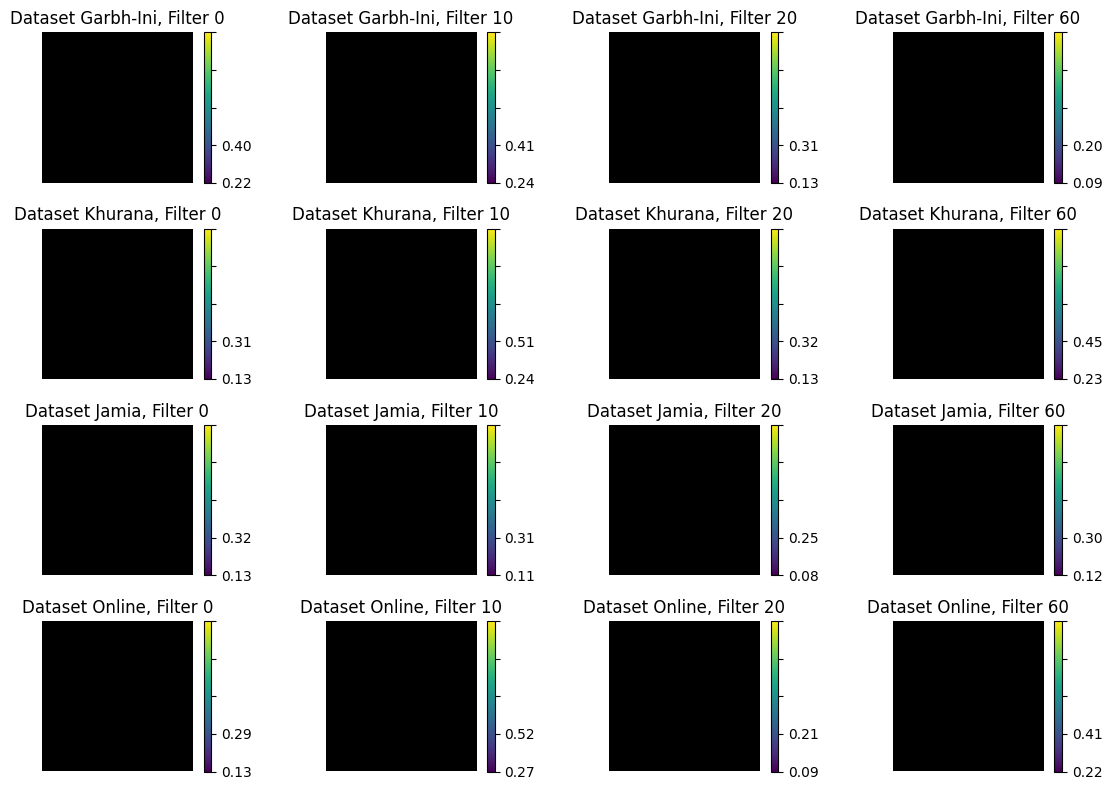

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ResNet34 model pretrained on ImageNet and move it to GPU
model = models.resnet34(pretrained=True).to(device)
model.eval()

def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0).to(device)

def deprocess_image(tensor):
    tensor = tensor.squeeze(0)
    mean = tensor.mean(dim=(1, 2), keepdim=True)
    std = tensor.std(dim=(1, 2), keepdim=True)
    tensor = tensor.mul(std).add(mean).clamp(0, 1)
    return tensor.permute(1, 2, 0).detach().cpu().numpy()

def visualize_activation_maximization(filter_index, img_path=None, iterations=100, lr=0.001):
    def hook_fn(module, input, output):
        visualize_activation_maximization.feature_map = output

    model.eval()

    hook = None
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            hook = layer.register_forward_hook(hook_fn)
            break

    img_tensor = preprocess_image(img_path)
    img_tensor.requires_grad_(True)

    for i in range(iterations):
        model.zero_grad()
        output = model(img_tensor)
        loss = -torch.mean(visualize_activation_maximization.feature_map[:, filter_index])
        loss.backward()

        img_tensor.data += lr * img_tensor.grad.data

    img = deprocess_image(img_tensor)
    if hook is not None:
        hook.remove()

    return img

# Define parameters for visualization
filter_indices = [0, 10, 20, 60]  # Different filter indices to visualize

# Define folder paths and allowed extensions for four different datasets
dataset_info = [
    {"folder_path": "/home/user/Desktop/aman/data/conf_img_garbh_images", "name": "Garbh-Ini", "allowed_extensions": ['.jpg', '.JPG', '.png']},
    {"folder_path": "/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID", "name": "Khurana", "allowed_extensions": ['.png', '.jpg']},
    {"folder_path": "/home/user/Desktop/aman/data/JAMIA_COHORT/final_cleaned_hc_images", "name": "Jamia", "allowed_extensions": ['.jpg', '.JPG', '.png']},
    {"folder_path": "/home/user/Desktop/aman/data/image_external_dataset/clean_training_set", "name": "Online", "allowed_extensions": ['.jpg', '.jpeg', '.png']}
]

# Calculate number of rows and columns for subplots
num_rows = len(dataset_info)
num_cols = len(filter_indices)

# Create figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Visualize activation maximization for each dataset
for row_idx, dataset in enumerate(dataset_info):
    folder_path = dataset["folder_path"]
    name = dataset["name"]
    allowed_extensions = dataset["allowed_extensions"]
    
    images_in_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and os.path.splitext(f)[1].lower() in allowed_extensions]
    
    for col_idx, filter_idx in enumerate(filter_indices):
        img_path = images_in_folder[col_idx % len(images_in_folder)]  # Cycle through images
        img = visualize_activation_maximization(filter_idx, img_path=img_path)

        # Plot image on corresponding subplot
        ax = axes[row_idx, col_idx]
        ax.imshow(img.astype('uint8'))
        ax.set_title(f'Dataset {name}, Filter {filter_idx}')
        ax.axis('off')

        # Add colorbar to show intensity range
        img_min, img_max = np.min(img), np.max(img)
        img_range = img_max - img_min
        cbar = ax.figure.colorbar(ax.imshow(img.astype('uint8')), ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_yticklabels([f'{img_min:.2f}', f'{img_max:.2f}'])

plt.tight_layout()
plt.show()



/tmp/ipykernel_352512/225251970.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')  # You can choose any other colormap from matplotlib
/tmp/ipykernel_352512/225251970.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{img_min:.2f}', f'{img_max:.2f}'])


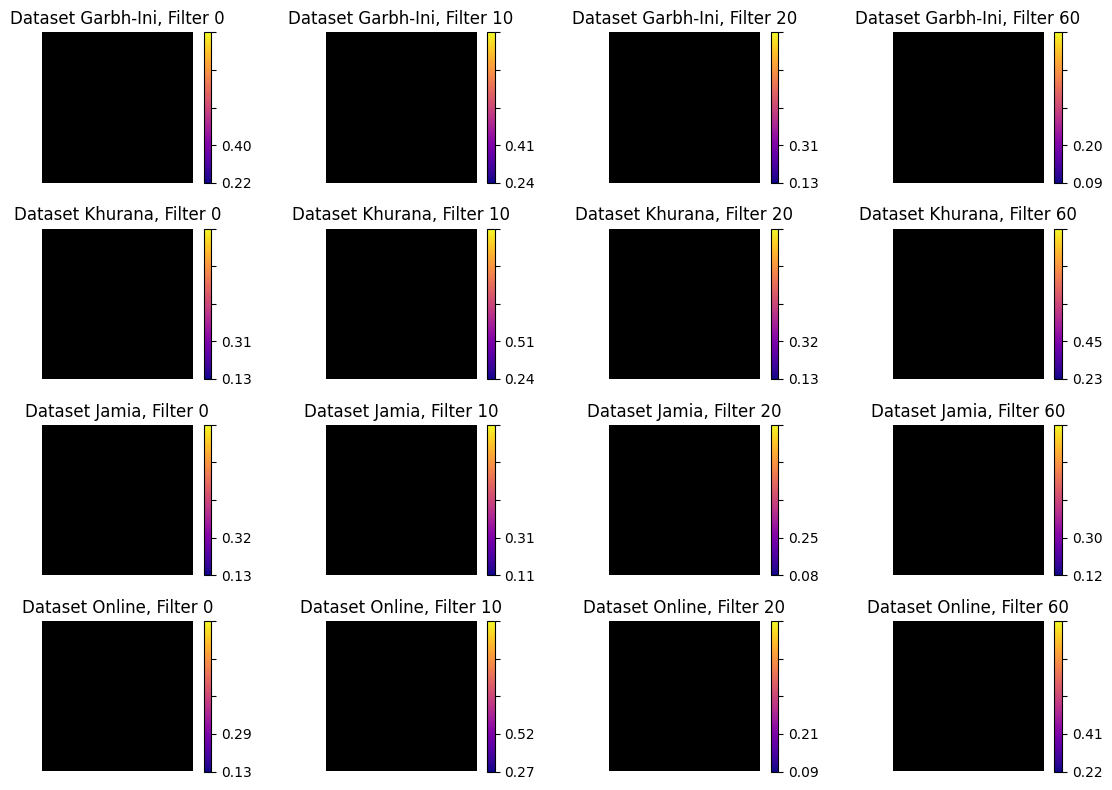

In [16]:
# Import additional library for colormaps
import matplotlib.cm as cm

# Define a colormap with more distinguishable colors
cmap = cm.get_cmap('plasma')  # You can choose any other colormap from matplotlib

# Create figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Visualize activation maximization for each dataset
for row_idx, dataset in enumerate(dataset_info):
    folder_path = dataset["folder_path"]
    name = dataset["name"]
    allowed_extensions = dataset["allowed_extensions"]
    
    images_in_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and os.path.splitext(f)[1].lower() in allowed_extensions]
    
    for col_idx, filter_idx in enumerate(filter_indices):
        img_path = images_in_folder[col_idx % len(images_in_folder)]  # Cycle through images
        img = visualize_activation_maximization(filter_idx, img_path=img_path)

        # Plot image on corresponding subplot
        ax = axes[row_idx, col_idx]
        im = ax.imshow(img.astype('uint8'), cmap=cmap)  # Use the defined colormap
        ax.set_title(f'Dataset {name}, Filter {filter_idx}')
        ax.axis('off')

        # Add colorbar to show intensity range
        img_min, img_max = np.min(img), np.max(img)
        img_range = img_max - img_min
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_yticklabels([f'{img_min:.2f}', f'{img_max:.2f}'])

plt.tight_layout()
plt.show()


In [ ]:
# heat map

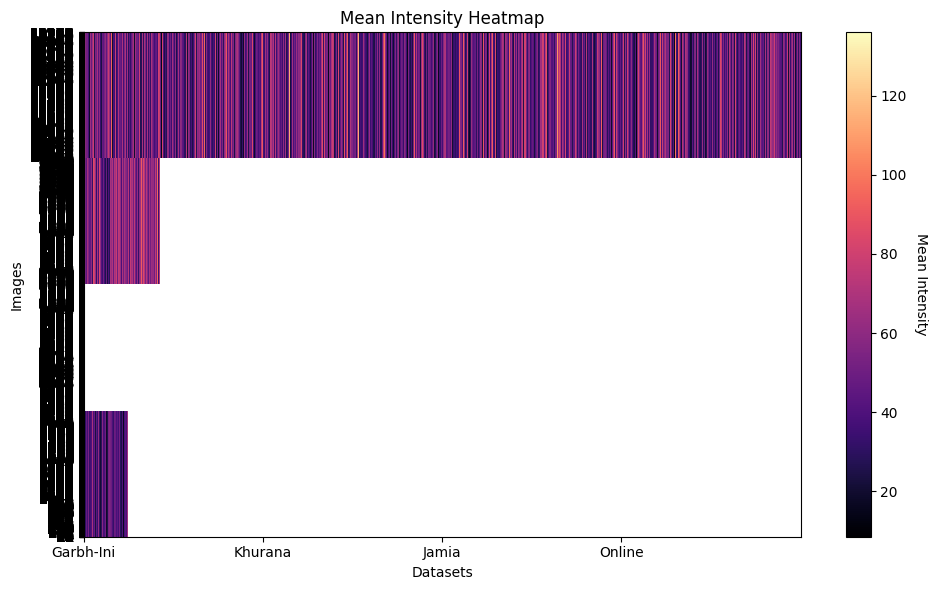

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to calculate mean intensity values for images in a folder
def calculate_mean_intensity(folder_path):
    mean_intensity_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.JPG', '.png', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mean_intensity_values.append(np.mean(img))
    return mean_intensity_values

# Define folder paths and dataset names for four different datasets
datasets = [
    {"name": "Garbh-Ini", "folder_path": "/home/user/Desktop/aman/data/conf_img_garbh_images"},
    {"name": "Khurana", "folder_path": "/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID"},
    {"name": "Jamia", "folder_path": "/home/user/Desktop/aman/data/JAMIA_COHORT/final_cleaned_hc_images"},
    {"name": "Online", "folder_path": "/home/user/Desktop/aman/data/image_external_dataset/clean_training_set"}
]

# Calculate mean intensity values for each dataset
# Calculate maximum number of images among all datasets
max_num_images = max(len(intensities) for intensities in dataset_intensity_values)

# Pad intensity values with NaNs to make each dataset have the same number of images
for intensities in dataset_intensity_values:
    num_images = len(intensities)
    if num_images < max_num_images:
        intensities.extend([np.nan] * (max_num_images - num_images))

# Convert dataset_intensity_values to a 2D numpy array
dataset_intensity_values = np.array(dataset_intensity_values)

# Plot the heatmap
extent = [0, len(datasets), 0, max_num_images]

# Plot the heatmap with extent and gaps
plt.figure(figsize=(10, 6))
plt.imshow(dataset_intensity_values, cmap='magma', aspect='auto', interpolation='nearest', extent=extent)

# Add colorbar to show scale
cbar = plt.colorbar()
cbar.set_label('Mean Intensity', rotation=270, labelpad=15)

# Set ticks and labels
plt.xticks(ticks=range(len(datasets)), labels=[dataset["name"] for dataset in datasets])
plt.yticks(ticks=np.arange(0, max_num_images), labels=np.arange(0, max_num_images) + 1)

# Set title and labels
plt.title('Mean Intensity Heatmap')
plt.xlabel('Datasets')
plt.ylabel('Images')

# Show plot
plt.tight_layout()
plt.show()


Number of images in Garbh-Ini: 13278
Number of images in Khurana: 1409
Number of images in Jamia: 1357
Number of images in Online: 806


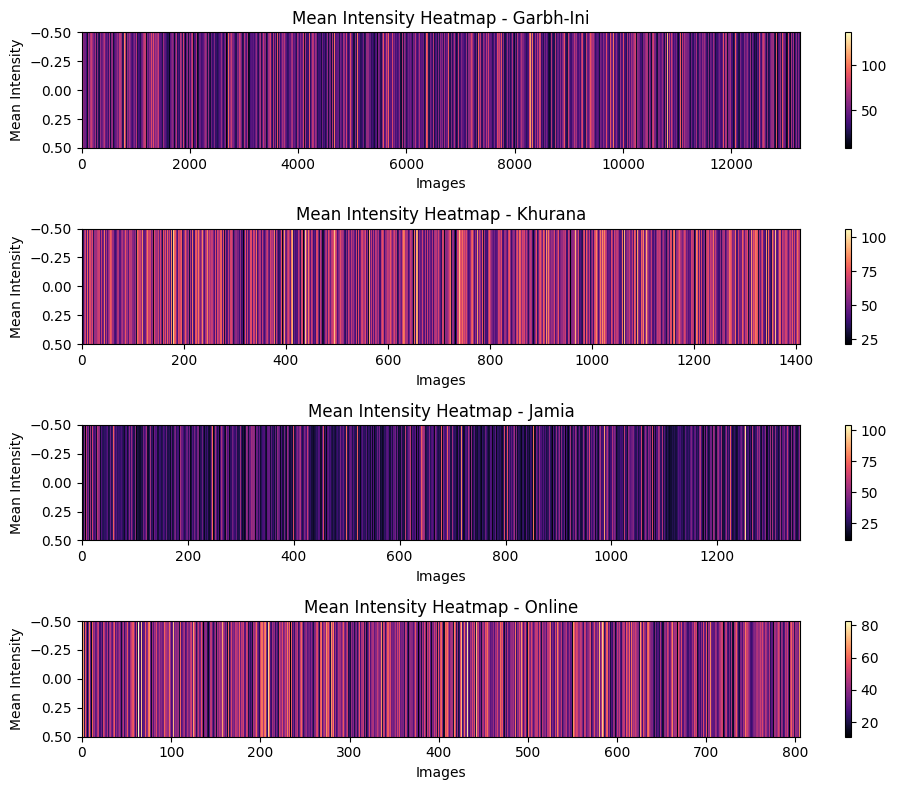

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to calculate mean intensity values for images in a folder
def calculate_mean_intensity(folder_path):
    mean_intensity_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mean_intensity_values.append(np.mean(img))
    return mean_intensity_values

# Define folder paths and dataset names for four different datasets
datasets = [
    {"name": "Garbh-Ini", "folder_path": "/home/user/Desktop/aman/data/conf_img_garbh_images"},
    {"name": "Khurana", "folder_path": "/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID"},
    {"name": "Jamia", "folder_path": "/home/user/Desktop/aman/data/JAMIA_COHORT/final_cleaned_hc_images"},
    {"name": "Online", "folder_path": "/home/user/Desktop/aman/data/image_external_dataset/clean_training_set"}
]

# Calculate mean intensity values for each dataset and print the number of images
for dataset in datasets:
    folder_path = dataset["folder_path"]
    intensity_values = calculate_mean_intensity(folder_path)
    num_images = len(intensity_values)
    print(f"Number of images in {dataset['name']}: {num_images}")

    dataset["intensity_values"] = intensity_values

# Plot the heatmap for each dataset
plt.figure(figsize=(10, 8))
for i, dataset in enumerate(datasets):
    plt.subplot(len(datasets), 1, i+1)
    plt.imshow([dataset["intensity_values"]], cmap='magma', aspect='auto', interpolation='nearest')
    cbar = plt.colorbar()  # Add colorbar to show scale
    cbar.ax.tick_params(labelsize=10)  # Adjust color bar tick label size
    plt.title(f'Mean Intensity Heatmap - {dataset["name"]}')
    plt.xlabel('Images')
    plt.ylabel('Mean Intensity')

plt.tight_layout()
plt.show()

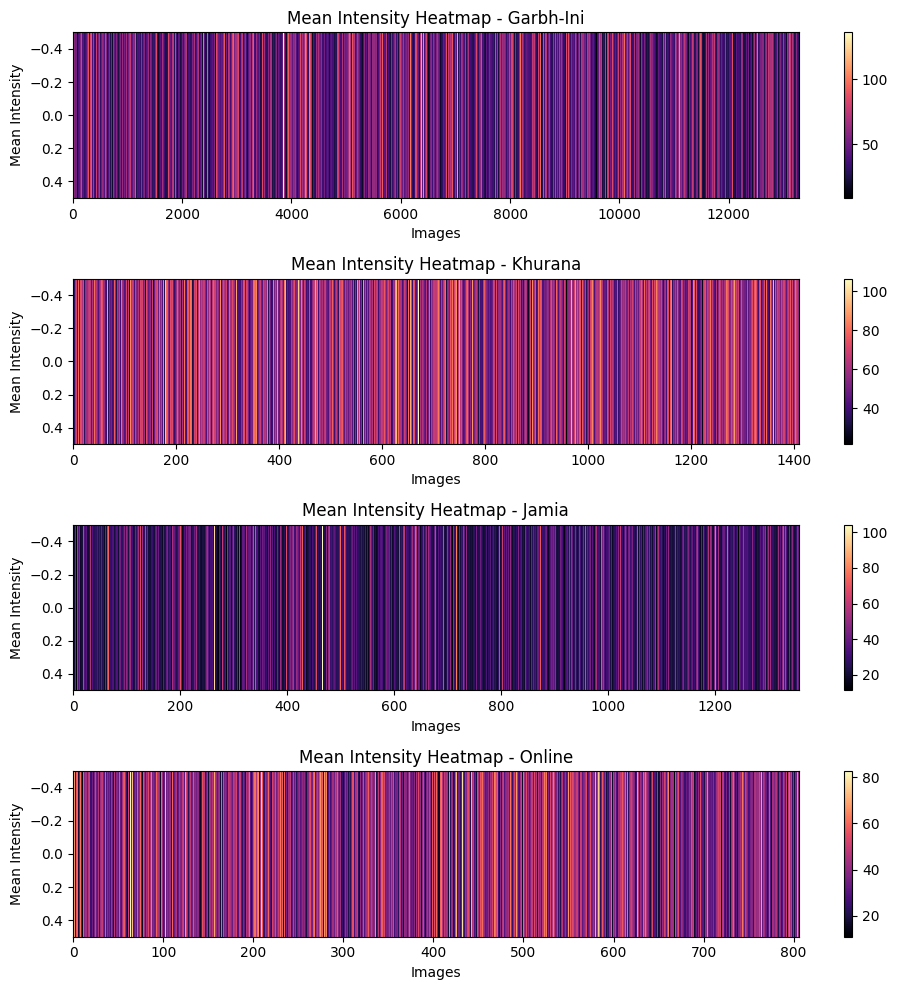

In [31]:
plt.figure(figsize=(10, 10))
for i, dataset in enumerate(datasets):
    plt.subplot(len(datasets), 1, i+1)
    plt.imshow([dataset["intensity_values"]], cmap='magma', aspect='auto', interpolation='nearest')
    cbar = plt.colorbar()  # Add colorbar to show scale
    cbar.ax.tick_params(labelsize=10)  # Adjust color bar tick label size
    plt.title(f'Mean Intensity Heatmap - {dataset["name"]}')
    plt.xlabel('Images')
    plt.ylabel('Mean Intensity')

plt.tight_layout()
plt.show()

Number of images in Garbh-Ini: 13278
Number of images in Khurana: 1409
Number of images in Jamia: 1357
Number of images in Online: 806


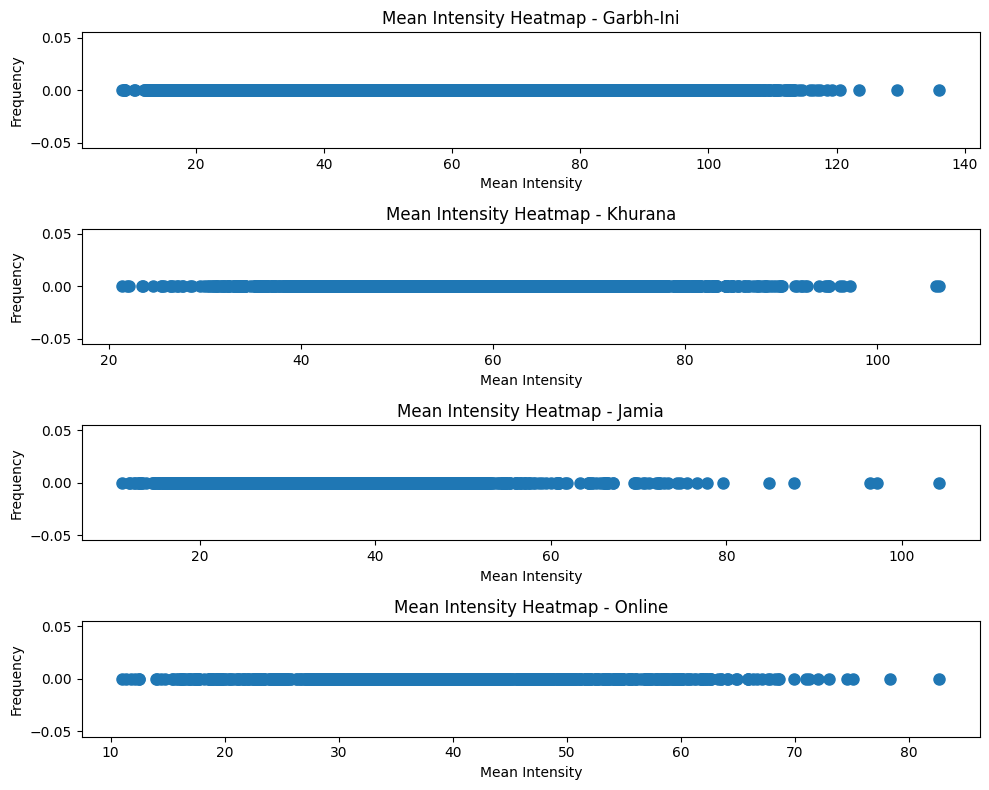

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to calculate mean intensity values for images in a folder
def calculate_mean_intensity(folder_path):
    mean_intensity_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mean_intensity_values.append(np.mean(img))
    return mean_intensity_values

# Define folder paths and dataset names for four different datasets
datasets = [
    {"name": "Garbh-Ini", "folder_path": "/home/user/Desktop/aman/data/conf_img_garbh_images"},
    {"name": "Khurana", "folder_path": "/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID"},
    {"name": "Jamia", "folder_path": "/home/user/Desktop/aman/data/JAMIA_COHORT/final_cleaned_hc_images"},
    {"name": "Online", "folder_path": "/home/user/Desktop/aman/data/image_external_dataset/clean_training_set"}
]

# Calculate mean intensity values for each dataset and print the number of images
for dataset in datasets:
    folder_path = dataset["folder_path"]
    intensity_values = calculate_mean_intensity(folder_path)
    num_images = len(intensity_values)
    print(f"Number of images in {dataset['name']}: {num_images}")

    # Aggregate intensity values with the same color
    intensity_values = np.unique(intensity_values)
    dataset["intensity_values"] = intensity_values

# Plot the heatmap for each dataset
plt.figure(figsize=(10, 8))
for i, dataset in enumerate(datasets):
    plt.subplot(len(datasets), 1, i+1)
    plt.plot(dataset["intensity_values"], np.zeros_like(dataset["intensity_values"]), 'o', markersize=8)
    plt.title(f'Mean Intensity Heatmap - {dataset["name"]}')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Number of images in Garbh-Ini: 13278
Number of images in Khurana: 1409
Number of images in Jamia: 1357
Number of images in Online: 806


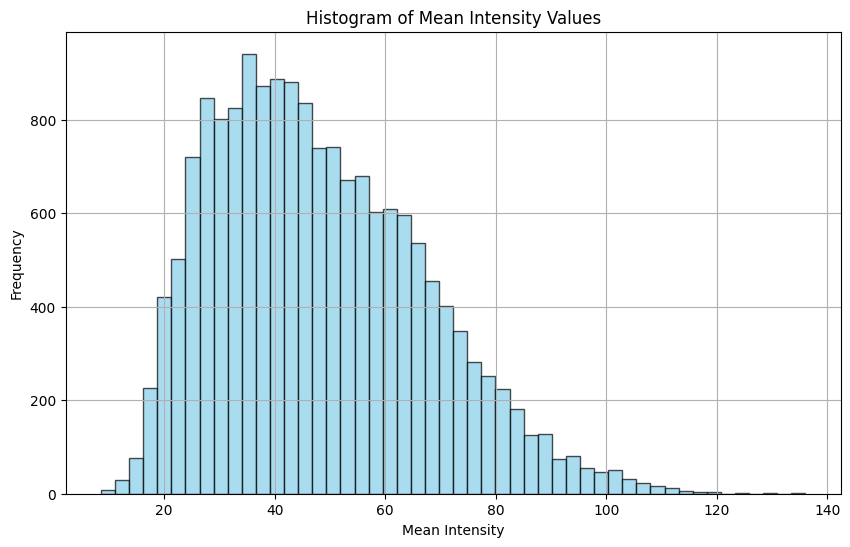

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to calculate mean intensity values for images in a folder
def calculate_mean_intensity(folder_path):
    mean_intensity_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mean_intensity_values.append(np.mean(img))
    return mean_intensity_values

# Define folder paths and dataset names for four different datasets
datasets = [
    {"name": "Garbh-Ini", "folder_path": "/home/user/Desktop/aman/data/conf_img_garbh_images"},
    {"name": "Khurana", "folder_path": "/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID"},
    {"name": "Jamia", "folder_path": "/home/user/Desktop/aman/data/JAMIA_COHORT/final_cleaned_hc_images"},
    {"name": "Online", "folder_path": "/home/user/Desktop/aman/data/image_external_dataset/clean_training_set"}
]

# Calculate mean intensity values for each dataset and print the number of images
all_intensity_values = []
for dataset in datasets:
    folder_path = dataset["folder_path"]
    intensity_values = calculate_mean_intensity(folder_path)
    num_images = len(intensity_values)
    print(f"Number of images in {dataset['name']}: {num_images}")
    all_intensity_values.extend(intensity_values)

# Plot the histogram for all datasets
plt.figure(figsize=(10, 6))
plt.hist(all_intensity_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Mean Intensity Values')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Number of images in Garbh-Ini: 13278
Number of images in Khurana: 1409
Number of images in Jamia: 1357
Number of images in Online: 806


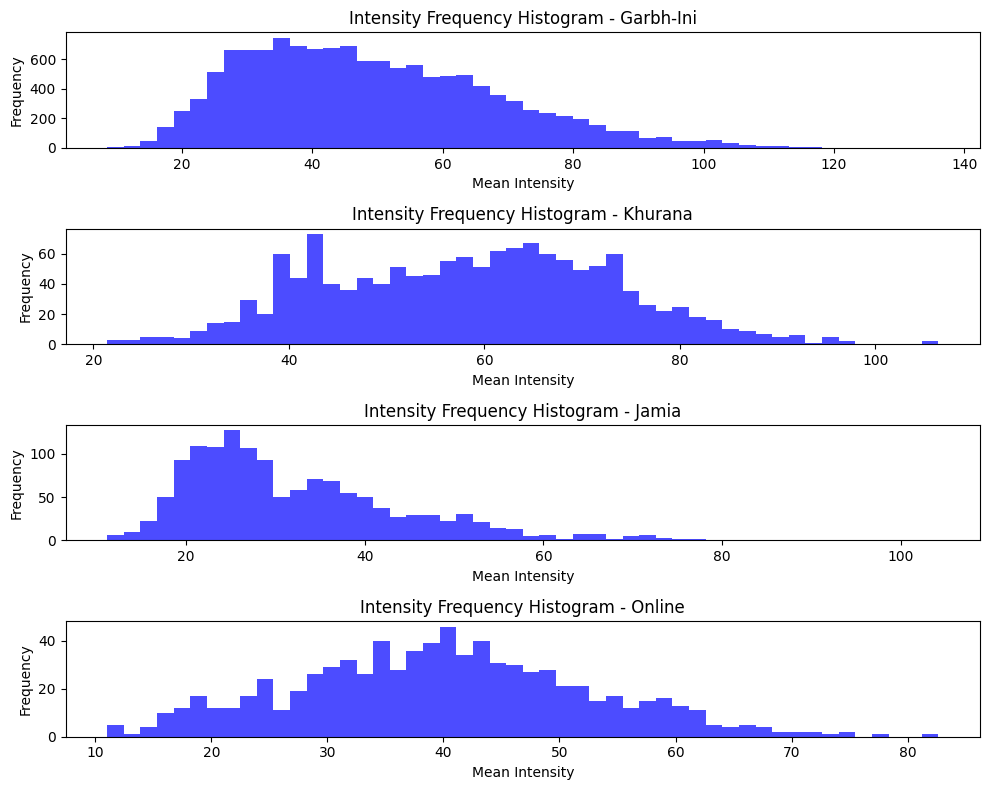

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to calculate mean intensity values for images in a folder
def calculate_mean_intensity(folder_path):
    mean_intensity_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mean_intensity_values.append(np.mean(img))
    return mean_intensity_values

# Define folder paths and dataset names for four different datasets
datasets = [
    {"name": "Garbh-Ini", "folder_path": "/home/user/Desktop/aman/data/conf_img_garbh_images"},
    {"name": "Khurana", "folder_path": "/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID"},
    {"name": "Jamia", "folder_path": "/home/user/Desktop/aman/data/JAMIA_COHORT/final_cleaned_hc_images"},
    {"name": "Online", "folder_path": "/home/user/Desktop/aman/data/image_external_dataset/clean_training_set"}
]

# Calculate mean intensity values for each dataset and print the number of images
for dataset in datasets:
    folder_path = dataset["folder_path"]
    intensity_values = calculate_mean_intensity(folder_path)
    num_images = len(intensity_values)
    print(f"Number of images in {dataset['name']}: {num_images}")

    dataset["intensity_values"] = intensity_values

# Plot the histograms for each dataset
plt.figure(figsize=(10, 8))
for i, dataset in enumerate(datasets):
    plt.subplot(len(datasets), 1, i+1)
    plt.hist(dataset["intensity_values"], bins=50, color='blue', alpha=0.7)
    plt.title(f'Intensity Frequency Histogram - {dataset["name"]}')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


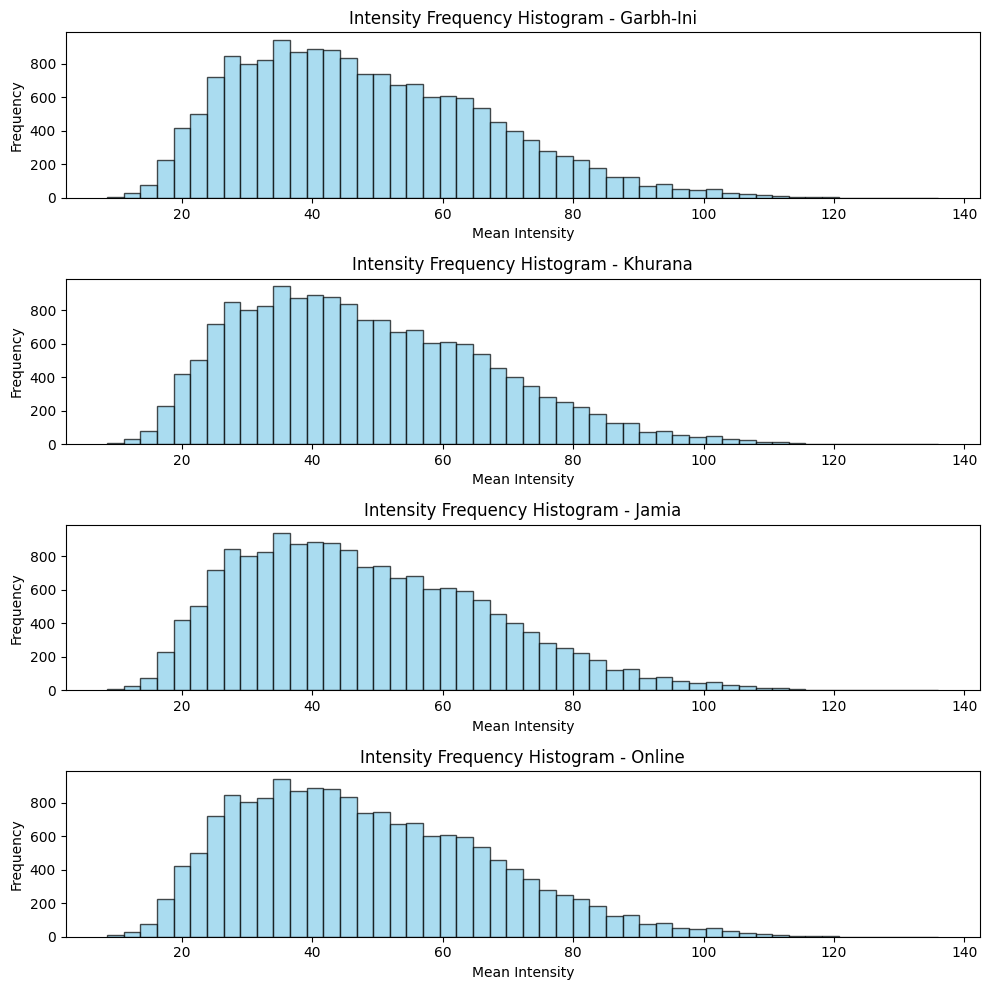

In [40]:
plt.figure(figsize=(10, 10))
for i, dataset in enumerate(datasets):
    plt.subplot(len(datasets), 1, i+1)
    plt.hist(all_intensity_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Intensity Frequency Histogram - {dataset["name"]}')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [6]:
# image cropping 

from PIL import Image

def crop_image_height(image_path, top_crop, bottom_crop):
    
    # Open the image
    image = Image.open(image_path)
   
    # Get the dimensions of the original image
    width, height = image.size
   
    # Calculate new height after cropping
    new_height = height - top_crop - bottom_crop
   
    # Crop the image
    cropped_image = image.crop((0, top_crop, width, height - bottom_crop))
   
    return cropped_image

# Example usage
input_image_path = '/home/user/Desktop/aman/DIVYA KUMARI_0017.JPG'
top_crop_pixels = 100  # Number of pixels to crop from the top
bottom_crop_pixels = 50  # Number of pixels to crop from the bottom

cropped_image = crop_image_height(input_image_path, top_crop_pixels, bottom_crop_pixels)

# Save or display the cropped image
cropped_image.show()
#cropped_image.save('cropped_image.jpg')  # Save the cropped image

In [ ]:
# Activation maximization

In [ ]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load pre-trained ResNet-34 model
resnet = models.resnet34(pretrained=True)
resnet.eval()

# Define hook to retrieve activations from the last convolutional layer
activation = {}
def hook(module, input, output):
    activation['value'] = output
resnet.layer4[1].register_forward_hook(hook)  # Register hook on the last convolutional layer of ResNet-34

# Function to calculate mean and standard deviation of activations
def calculate_mean_sd(image_folder):
    activations_list = []

    # Load and preprocess images, forward pass through the model, and collect activations
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"): 
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            image_tensor = transform(image)
            image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

            with torch.no_grad():
                _ = resnet(image_tensor)

            activations = activation['value'].squeeze().cpu().numpy()
            activations_list.append(activations)

    # Calculate mean and standard deviation of activations
    activations_array = np.array(activations_list)
    mean_activations = np.mean(activations_array, axis=(0, 2, 3))  # Mean along batch and spatial dimensions
    std_activations = np.std(activations_array, axis=(0, 2, 3))    # Standard deviation along batch and spatial dimensions

    return mean_activations, std_activations

# Ask for image folder path
image_folder = ("/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID")

# Calculate mean and standard deviation of activations
mean_activations, std_activations = calculate_mean_sd(image_folder)
print("Mean of activations:", mean_activations)
print("Standard deviation of activations:", std_activations)

# Re-define transform with calculated mean and standard deviation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_activations, std=std_activations),
])

# You can now use this transform for loading and preprocessing images for further processing.


In [ ]:
image_folder = ("/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID")


Mean: tensor([0.2139, 0.2333, 0.2465], device='cuda:0')
Std: tensor([0.1744, 0.1866, 0.1891], device='cuda:0')


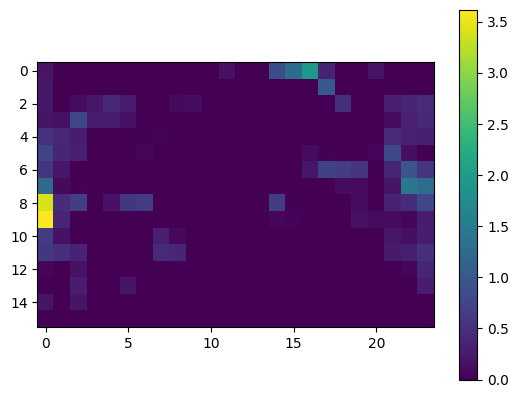

In [19]:
import os
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-34 model
resnet = models.resnet34(pretrained=True).to(device)
resnet.eval()

# Define hook to retrieve activations from the last convolutional layer
activation = {}
def hook(module, input, output):
    activation['value'] = output
resnet.layer4[1].register_forward_hook(hook)  # Register hook on the last convolutional layer of ResNet-34

# Function to calculate mean and standard deviation of input images
def calculate_mean_std(image_folder, device):
    transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
    ])
    mean = 0.0
    std = 0.0
    total_images = 0
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image).to(device)
            mean += image_tensor.mean((1, 2))
            std += image_tensor.std((1, 2))
            total_images += 1
    mean /= total_images
    std /= total_images
    return mean, std

# Ask for image folder path
image_folder = ("/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID")


# Calculate mean and standard deviation of input images
mean, std = calculate_mean_std(image_folder, device)
print("Mean:", mean)
print("Std:", std)

# Define transform with calculated mean and standard deviation
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Load and preprocess an example image
example_image_path = os.path.join(image_folder, os.listdir(image_folder)[0])  # Choose first image as example
example_image = Image.open(example_image_path).convert('RGB')  # Ensure image is RGB
example_tensor = transform(example_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Forward pass the example image through the model
with torch.no_grad():
    _ = resnet(example_tensor)

# Visualize the activations of the first channel
activation_map = activation['value'].squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU

plt.imshow(activation_map[0], cmap='viridis')
plt.colorbar()
plt.show()


In [22]:
def plot_activation_map(image_tensor, activation_map):
    # Convert activation map to a grayscale image
    activation_map = activation_map[0]

    # Normalize the activation map
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

    # Overlay activation map on the original image
    plt.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.imshow(activation_map, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.show()


# Function to calculate mean and standard deviation of input images


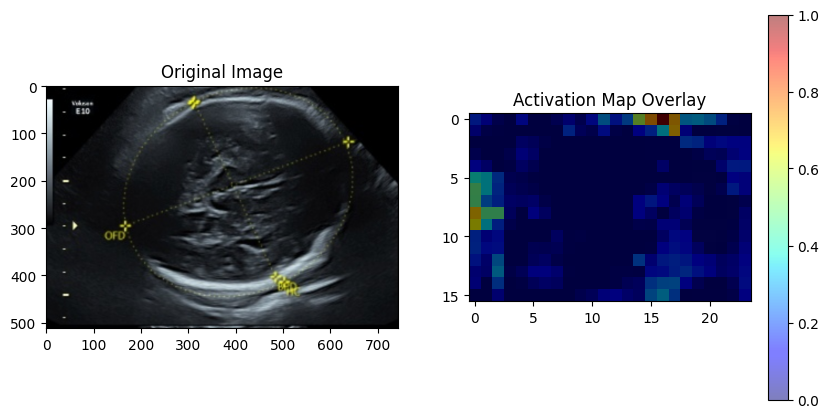

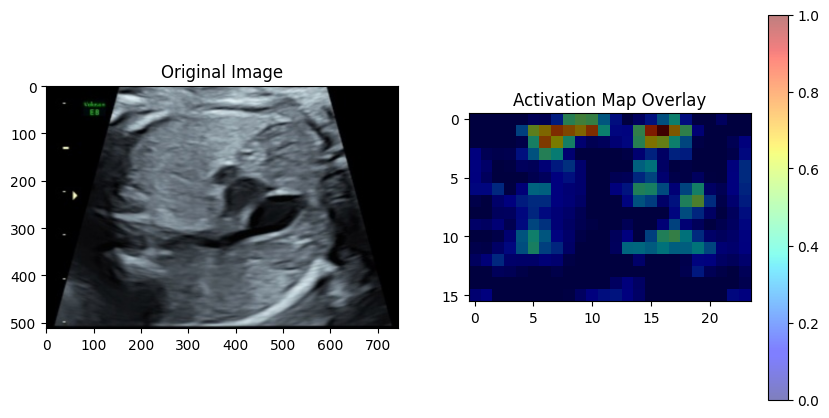

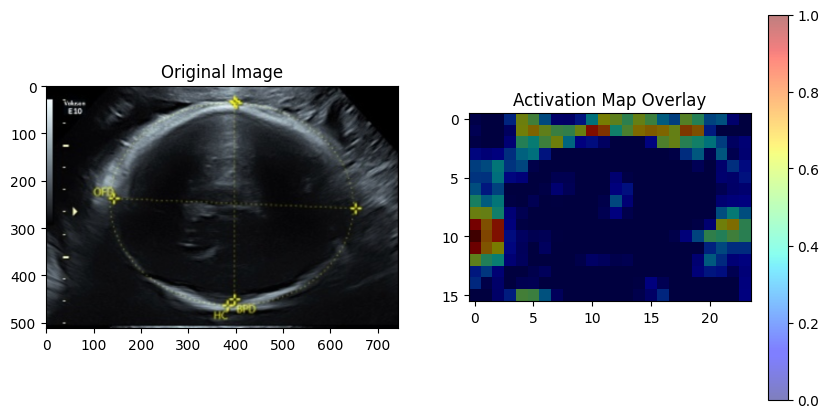

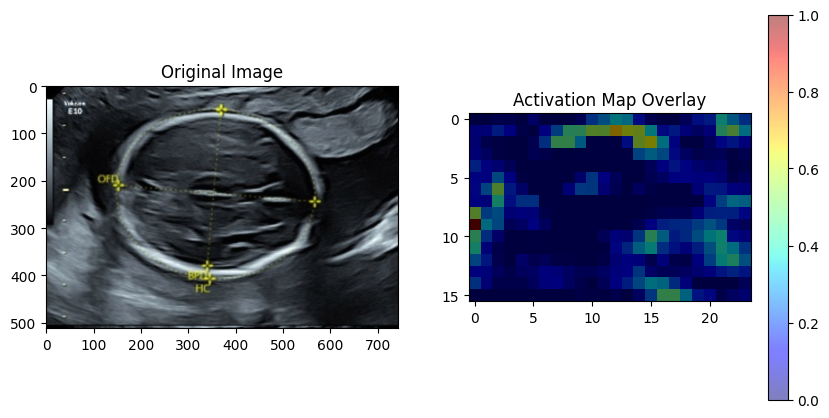

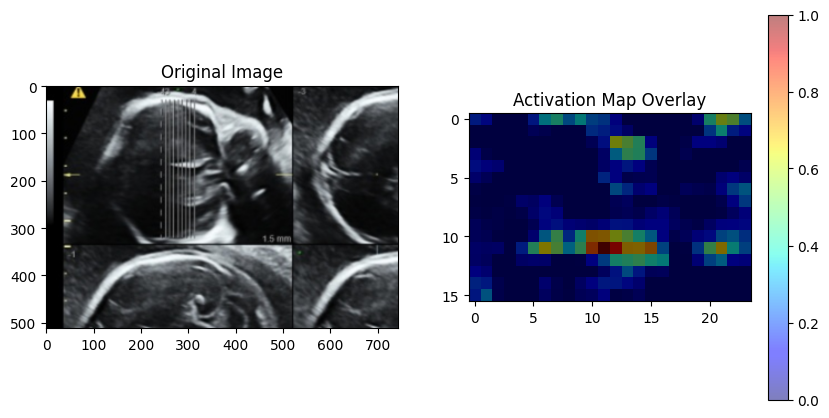

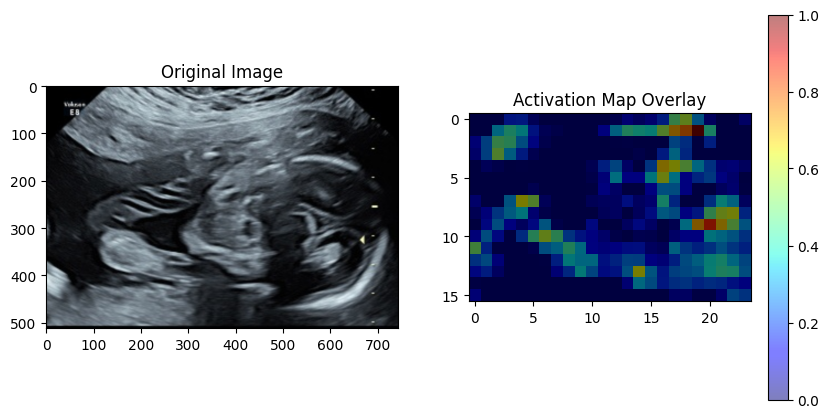

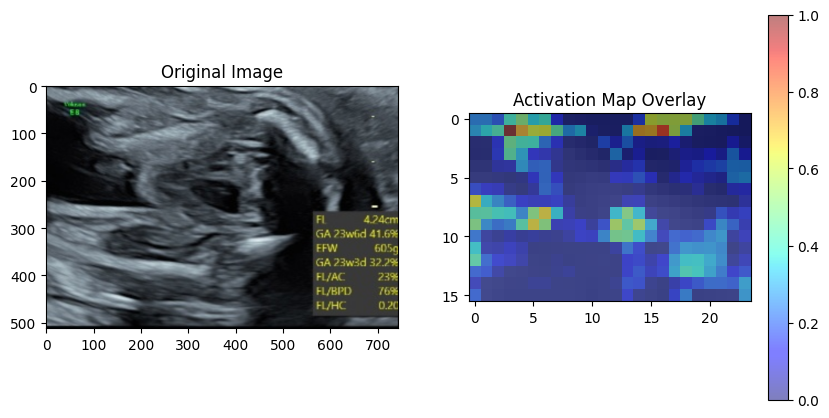

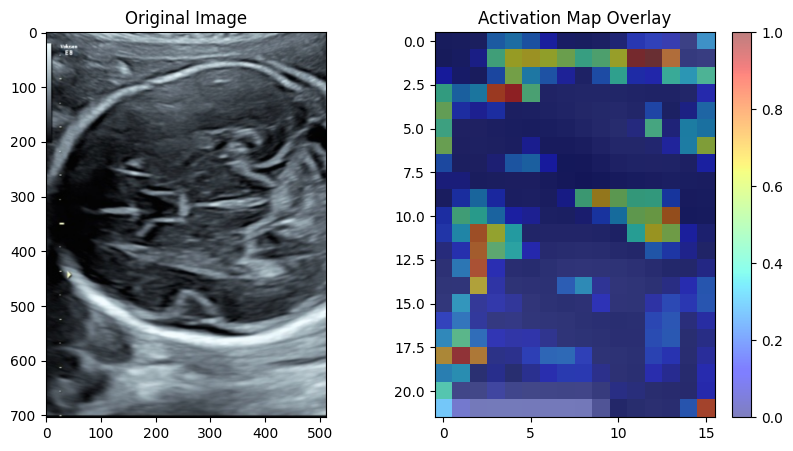

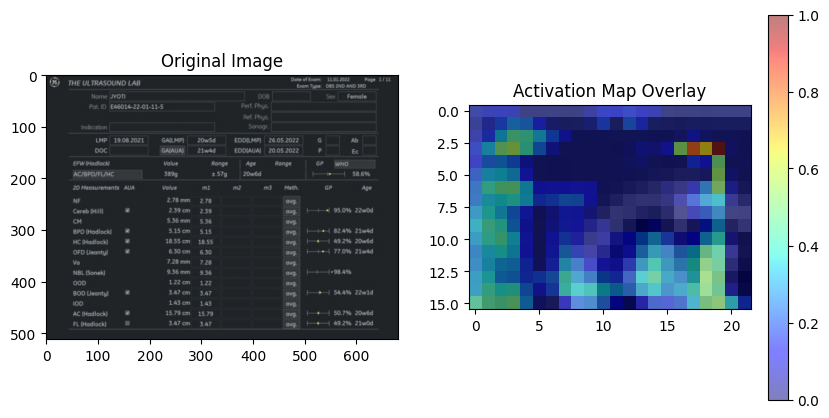

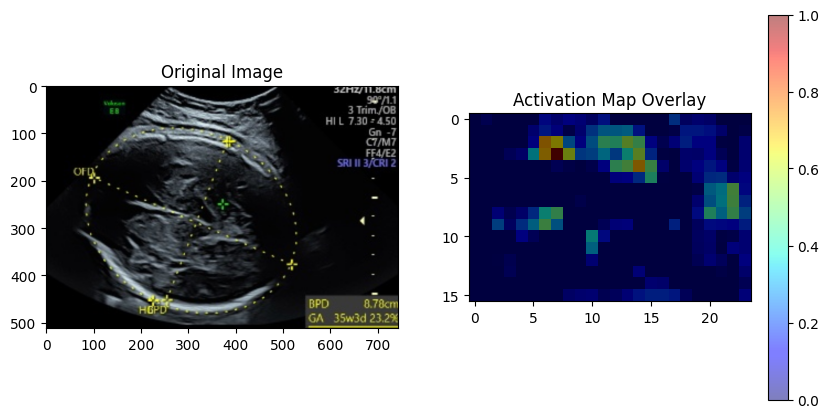

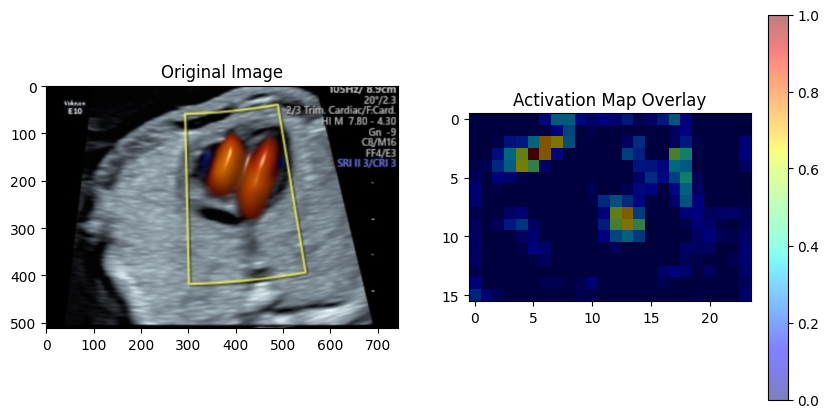

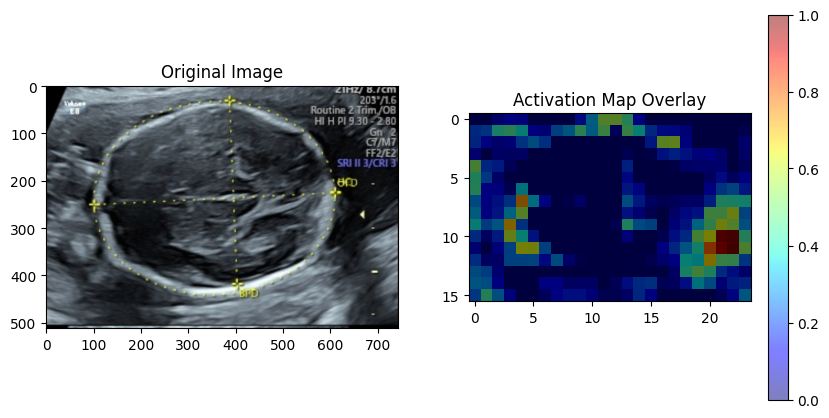

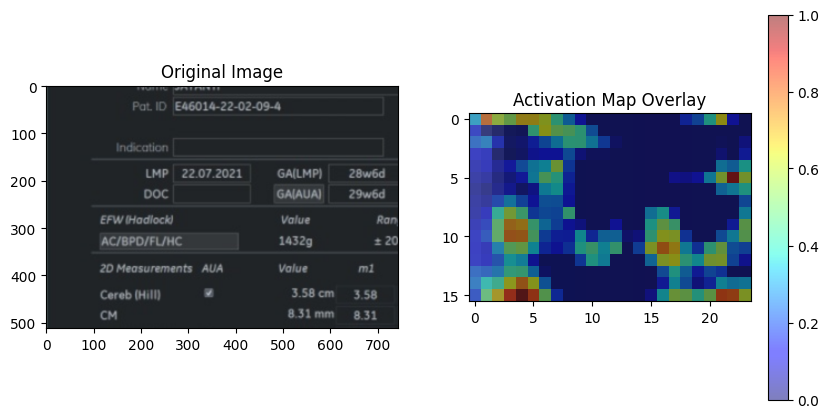

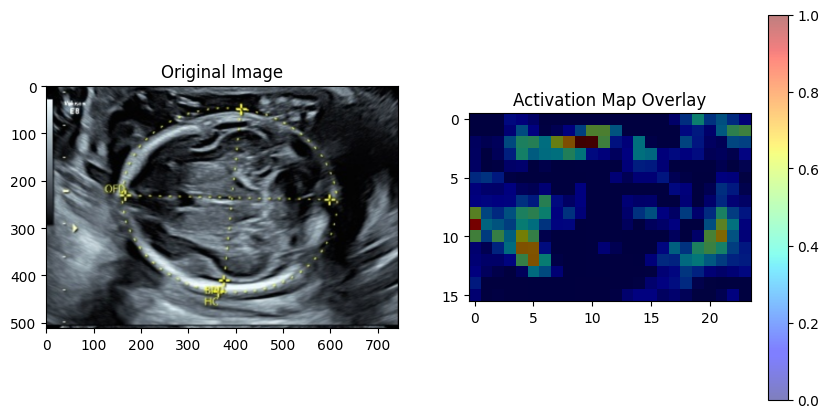

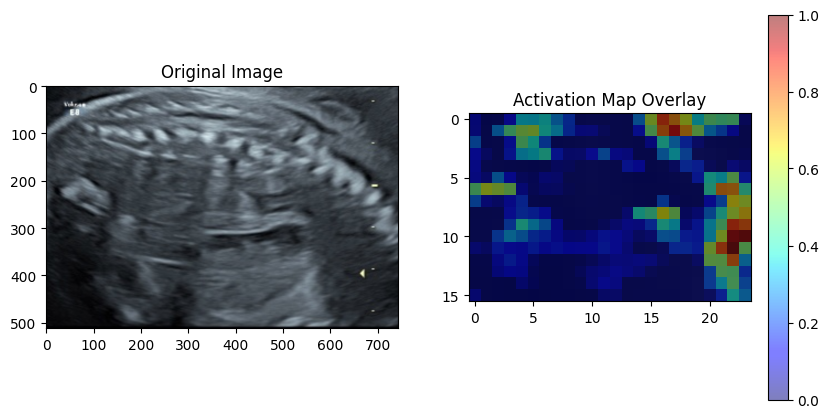

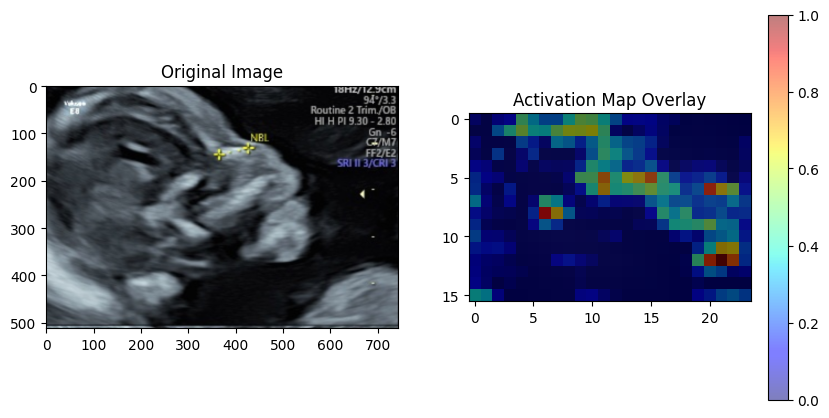

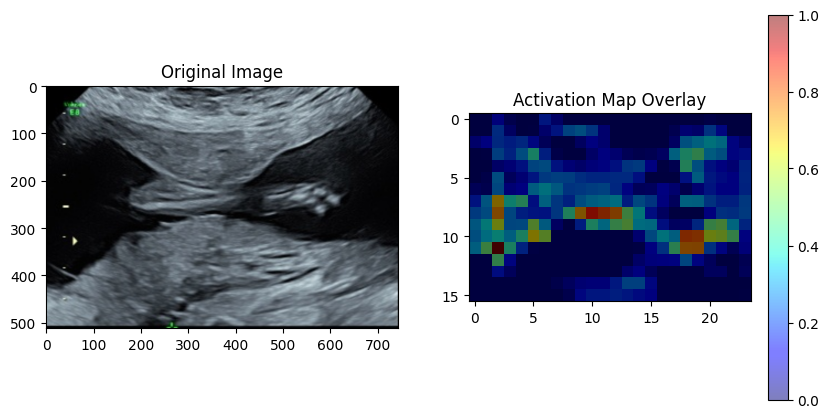

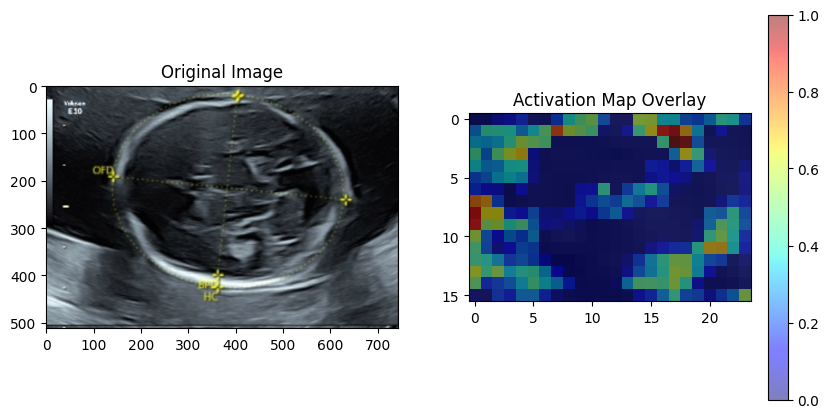

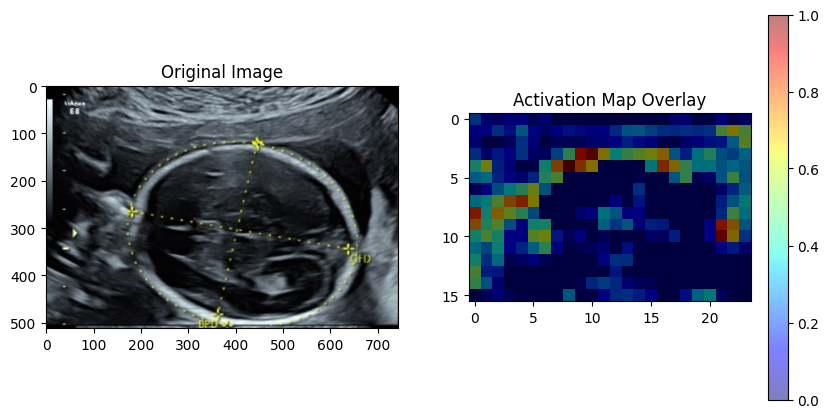

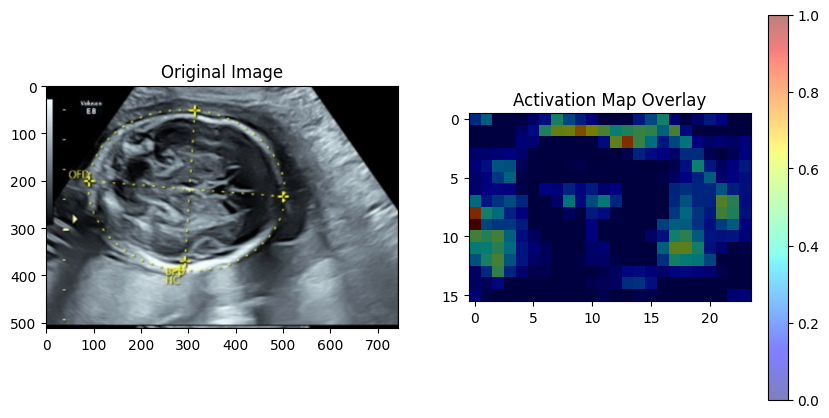

Mean: tensor([0.2139, 0.2333, 0.2465], device='cuda:0')
Std: tensor([0.1744, 0.1866, 0.1891], device='cuda:0')


In [33]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-34 model
resnet = models.resnet34(pretrained=True).to(device)
resnet.eval()

# Define hook to retrieve activations from the last convolutional layer
activation = {}
def hook(module, input, output):
    activation['value'] = output
resnet.layer4[1].register_forward_hook(hook)  # Register hook on the last convolutional layer of ResNet-34

# Function to plot activation map overlay on the original image
def plot_activation_map(image_tensor, activation_map):
    # Convert activation map to a grayscale image
    activation_map = activation_map[0]

    # Normalize the activation map
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

    # Overlay activation map on the original image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
    ax1.set_title('Original Image')

    ax2.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
    im = ax2.imshow(activation_map, cmap='jet', alpha=0.5)
    ax2.set_title('Activation Map Overlay')
    fig.colorbar(im, ax=ax2)
    plt.show()


# Function to calculate mean and standard deviation of input images
def calculate_mean_std(image_folder, device):
    transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
    ])
    mean = 0.0
    std = 0.0
    total_images = 0
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image).to(device)
            mean += image_tensor.mean((1, 2))
            std += image_tensor.std((1, 2))
            total_images += 1
            if total_images <= 20:  # Visualize only for the first 5 images
                # Forward pass the image through the model
                with torch.no_grad():
                    _ = resnet(image_tensor.unsqueeze(0))

                # Visualize the activations of the first channel
                activation_map = activation['value'].squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
                plot_activation_map(image_tensor, activation_map)

    mean /= total_images
    std /= total_images
    return mean, std

# Ask for image folder path
image_folder = ("/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID")

# Calculate mean and standard deviation of input images
mean, std = calculate_mean_std(image_folder, device)
print("Mean:", mean)
print("Std:", std)


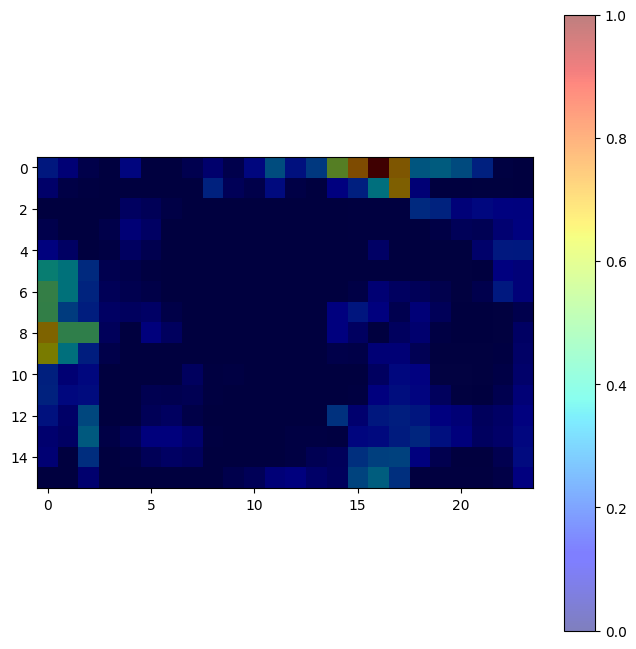

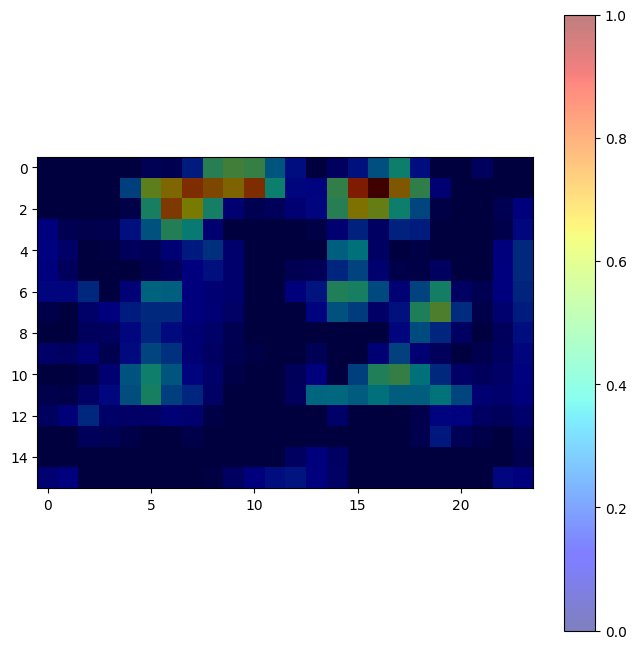

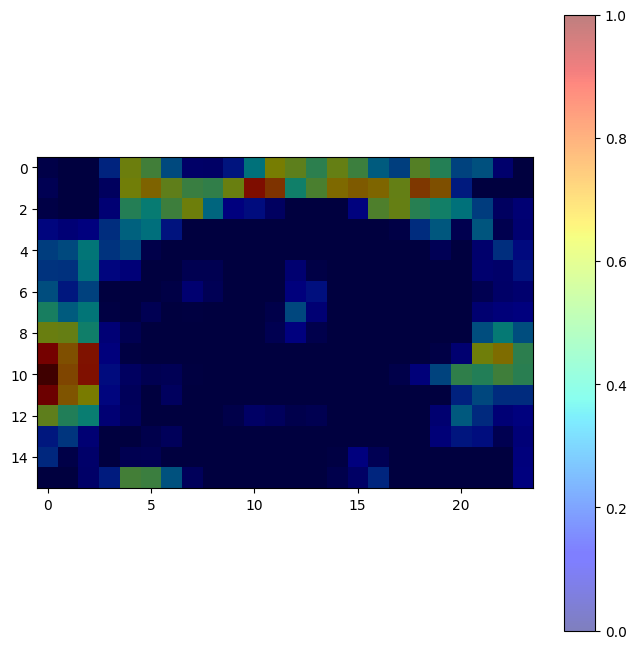

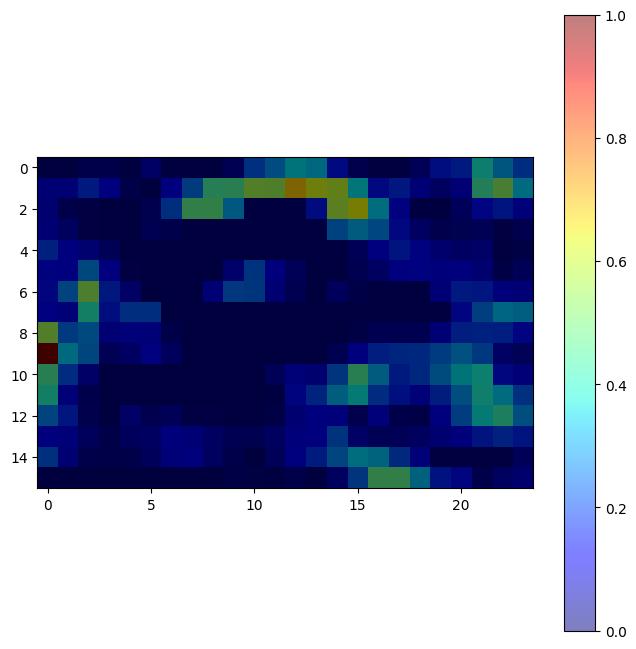

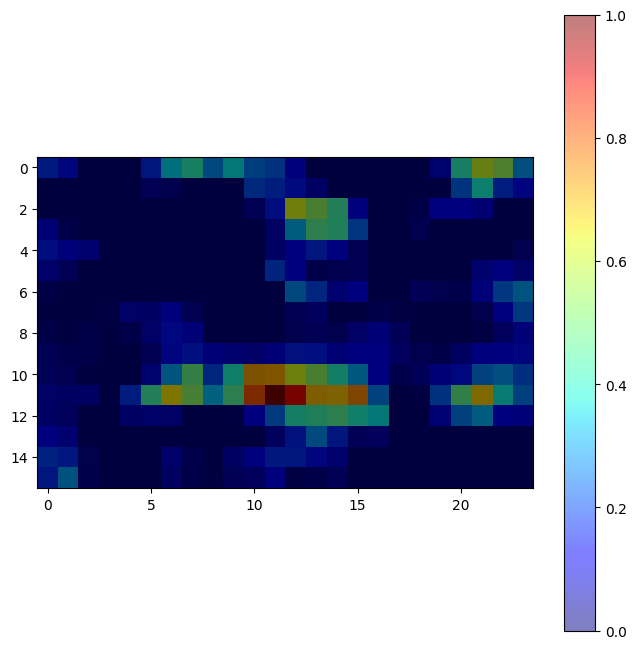

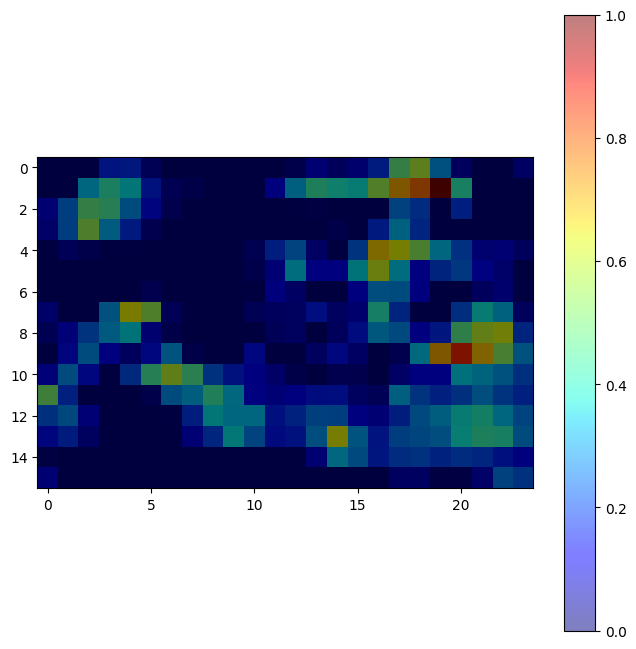

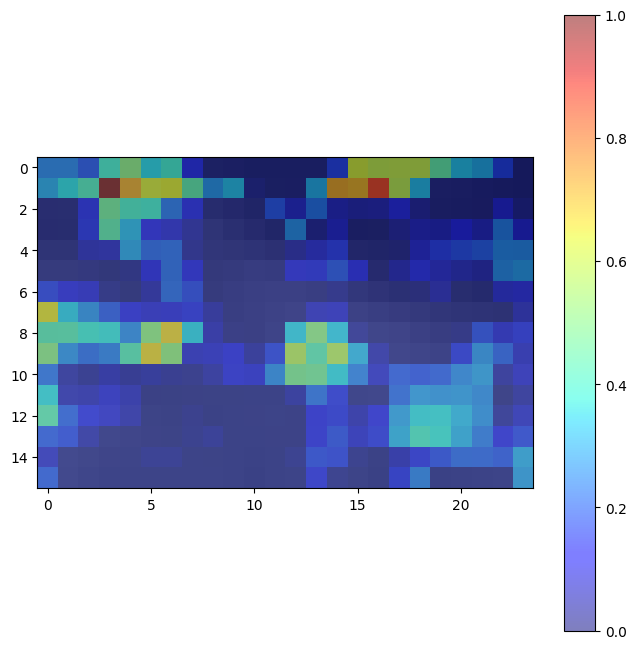

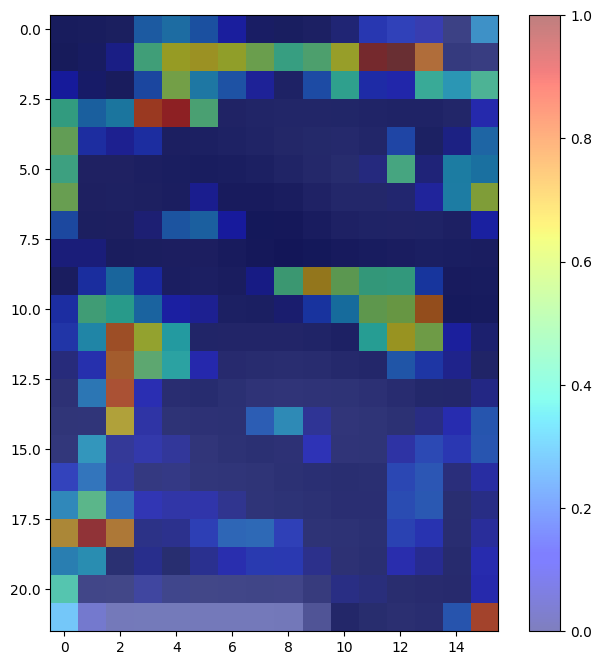

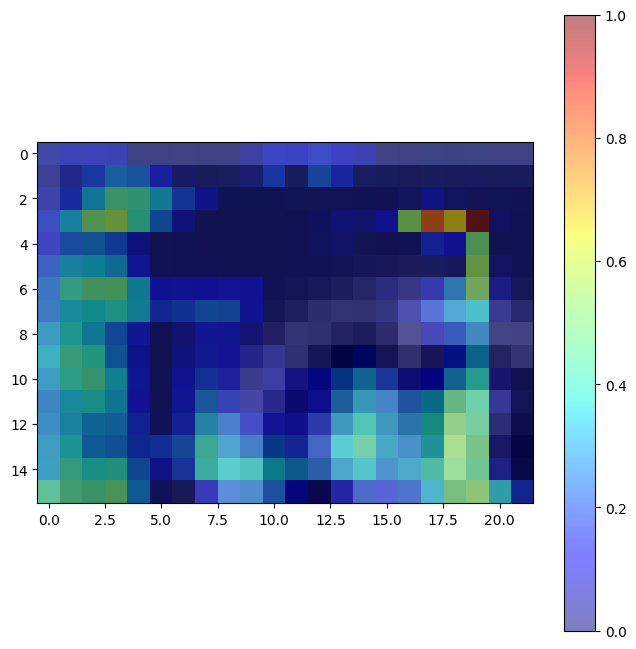

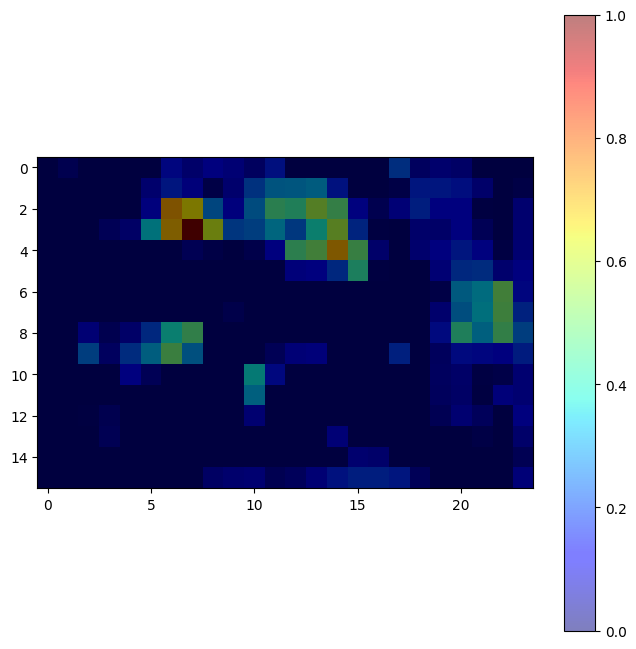

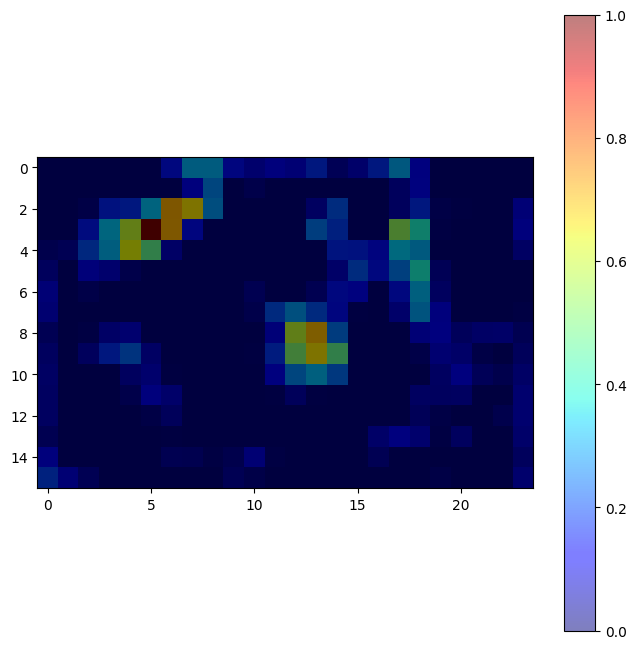

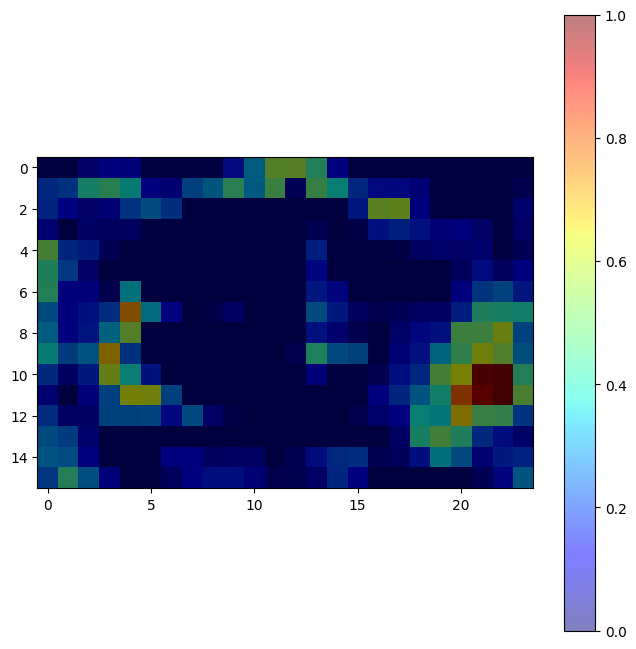

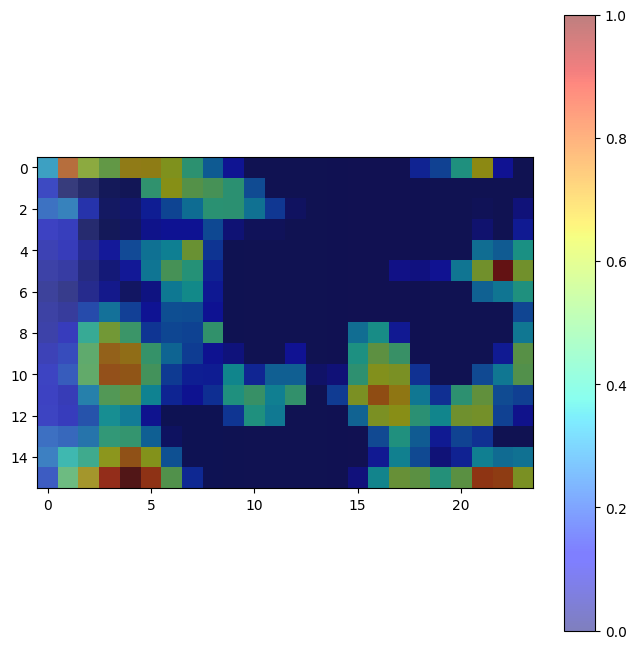

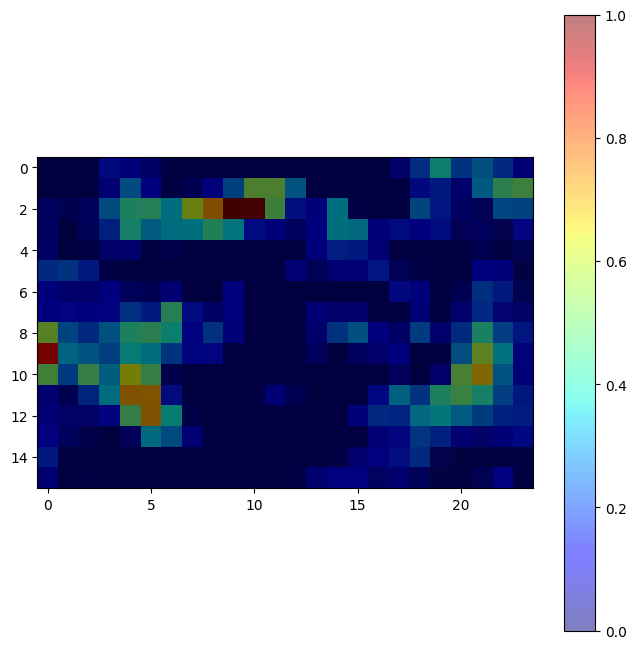

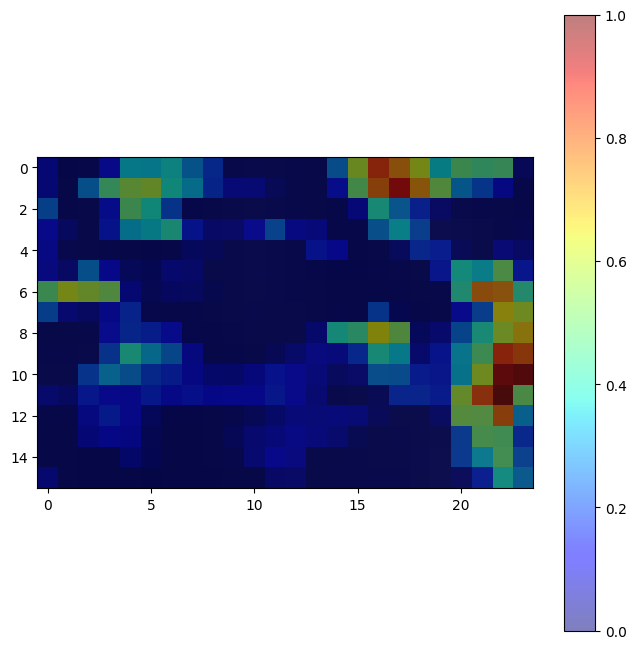

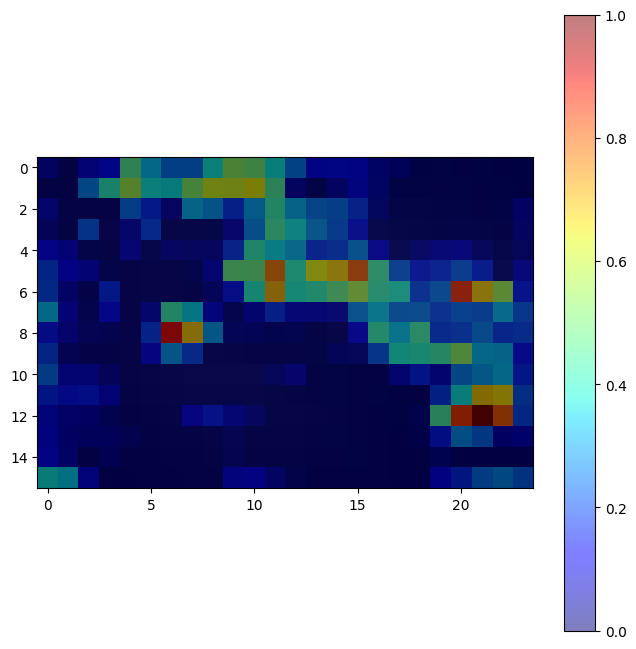

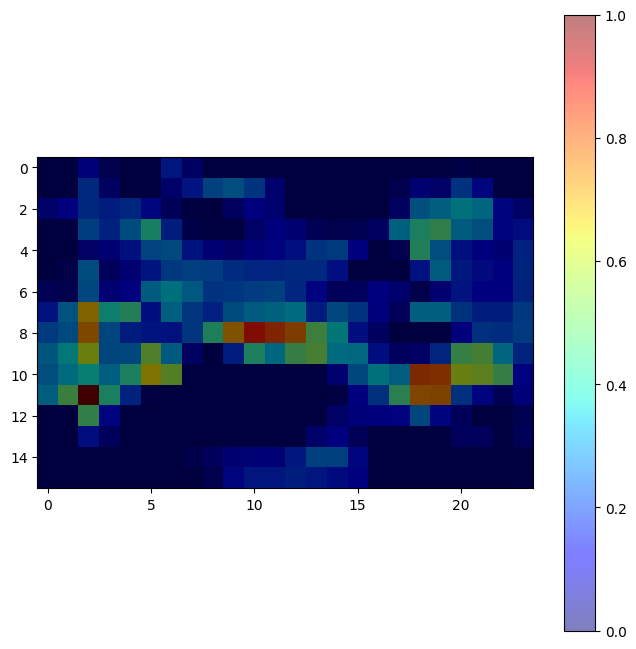

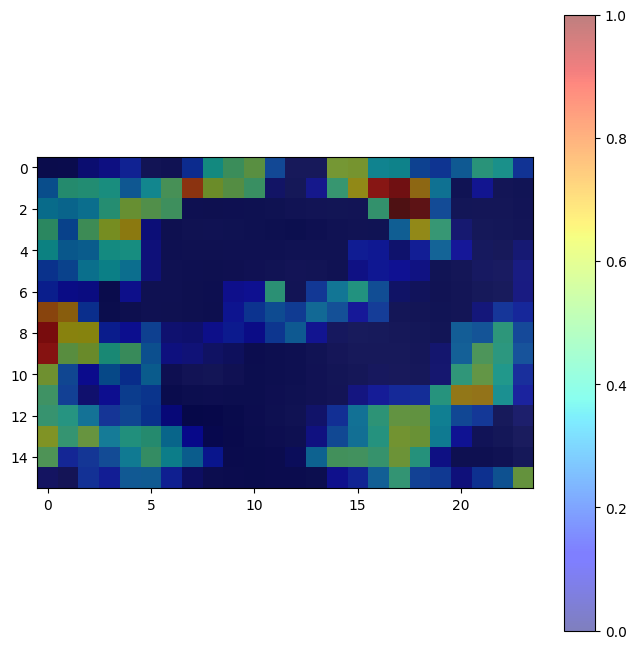

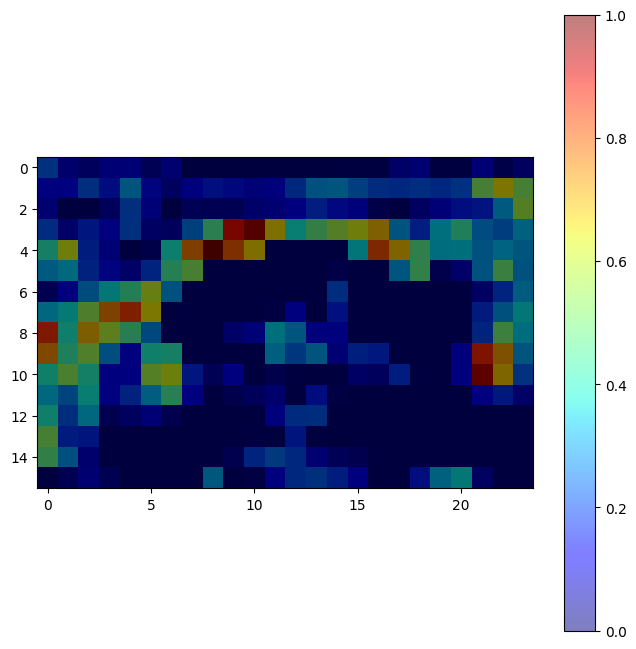

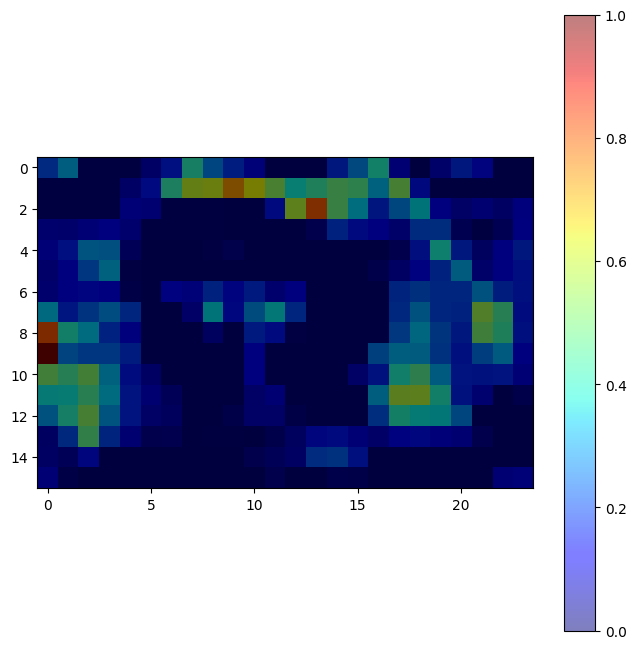

Mean: tensor([0.2139, 0.2333, 0.2465], device='cuda:0')
Std: tensor([0.1744, 0.1866, 0.1891], device='cuda:0')


In [34]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-34 model
resnet = models.resnet34(pretrained=True).to(device)
resnet.eval()

# Define hook to retrieve activations from the last convolutional layer
activation = {}
def hook(module, input, output):
    activation['value'] = output
resnet.layer4[1].register_forward_hook(hook)  # Register hook on the last convolutional layer of ResNet-34

# Function to plot activation map overlay on the original image
def plot_activation_map(image_tensor, activation_map):
    # Convert activation map to a grayscale image
    activation_map = activation_map[0]

    # Normalize the activation map
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

    # Overlay activation map on the original image
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
    im = ax.imshow(activation_map, cmap='jet', alpha=0.5)
    fig.colorbar(im, ax=ax)
    plt.show()



# Function to calculate mean and standard deviation of input images
def calculate_mean_std(image_folder, device):
    transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
    ])
    mean = 0.0
    std = 0.0
    total_images = 0
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image).to(device)
            mean += image_tensor.mean((1, 2))
            std += image_tensor.std((1, 2))
            total_images += 1
            if total_images <= 20:  # Visualize only for the first 5 images
                # Forward pass the image through the model
                with torch.no_grad():
                    _ = resnet(image_tensor.unsqueeze(0))

                # Visualize the activations of the first channel
                activation_map = activation['value'].squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
                plot_activation_map(image_tensor, activation_map)

    mean /= total_images
    std /= total_images
    return mean, std

# Ask for image folder path
image_folder = ("/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID")

# Calculate mean and standard deviation of input images
mean, std = calculate_mean_std(image_folder, device)
print("Mean:", mean)
print("Std:", std)


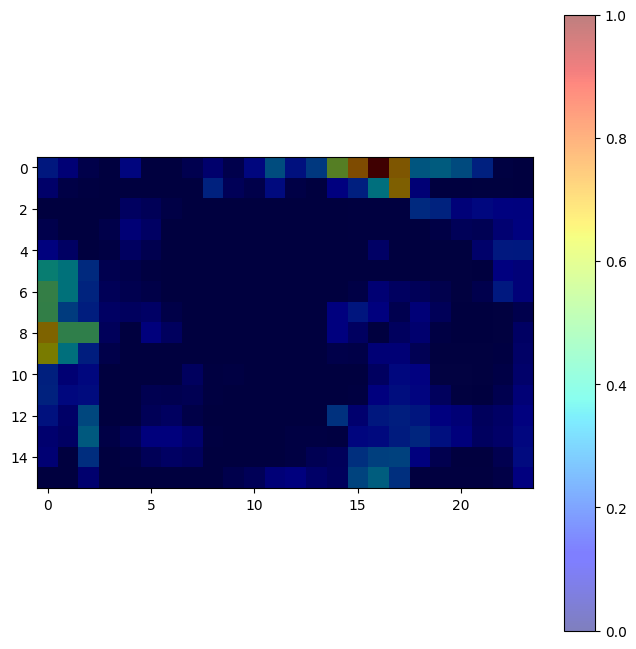

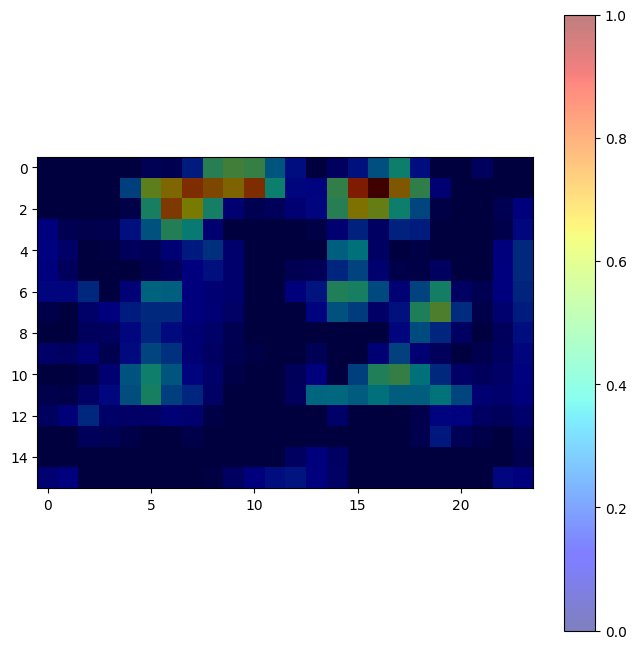

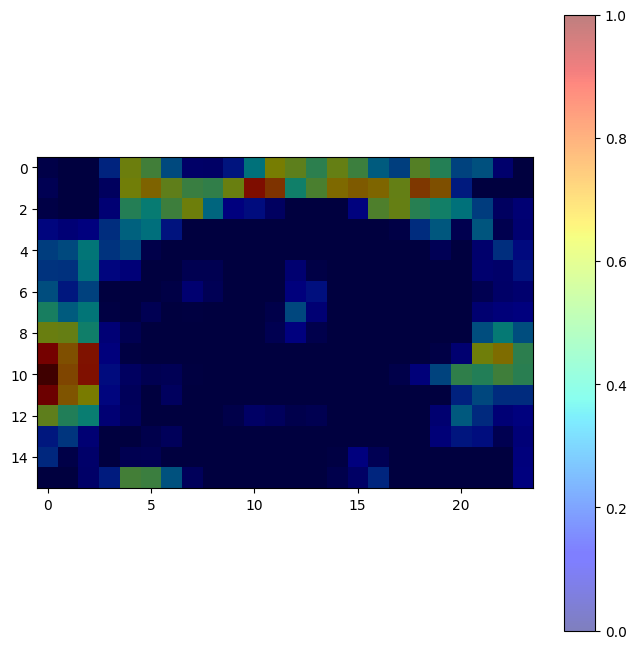

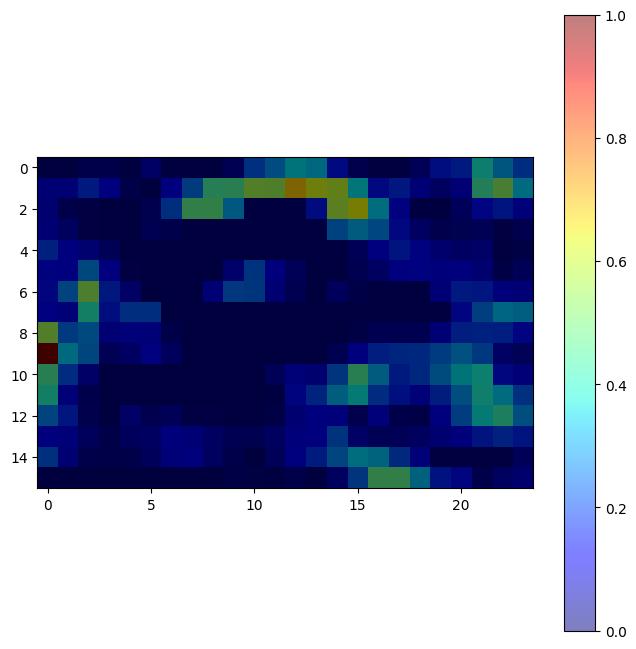

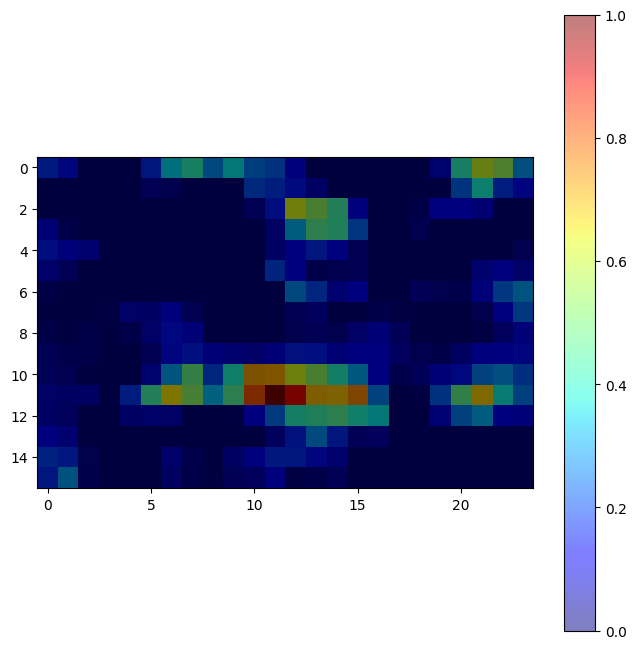

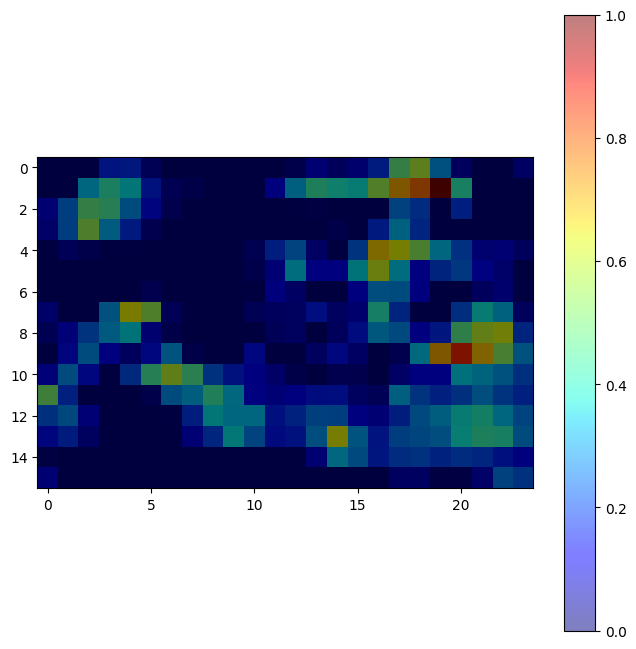

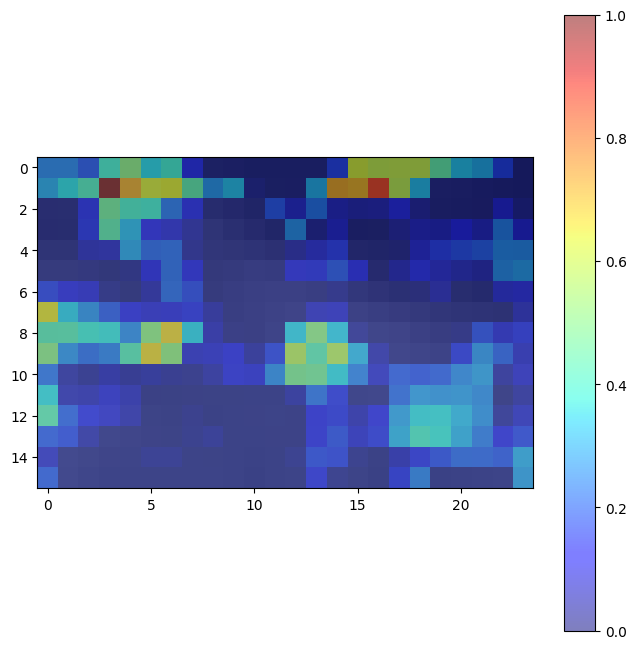

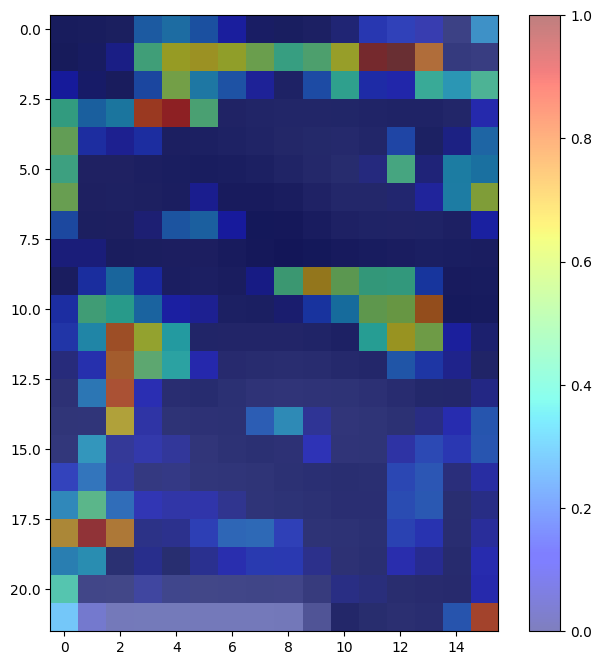

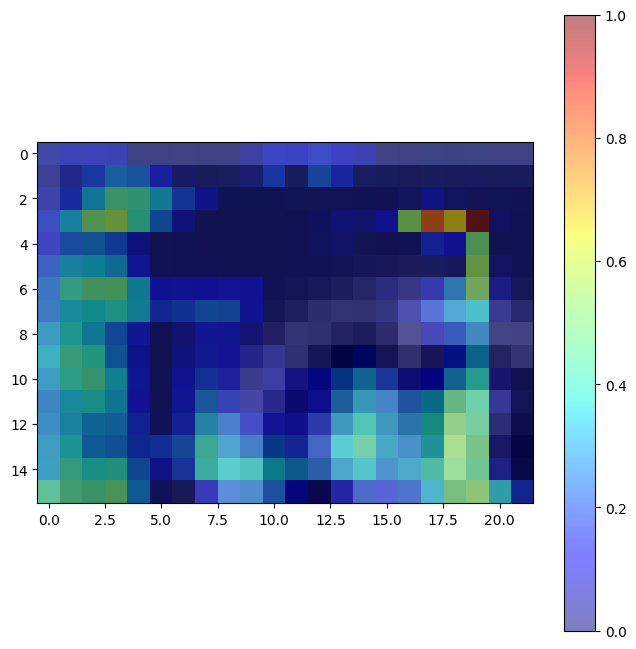

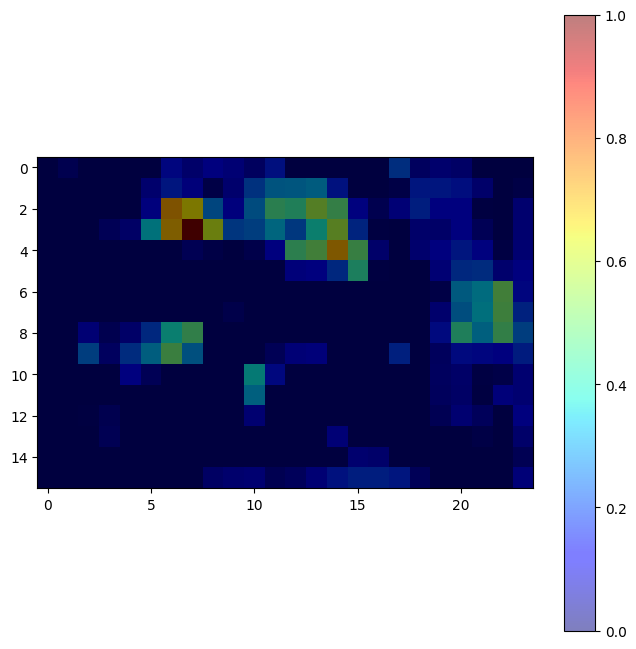

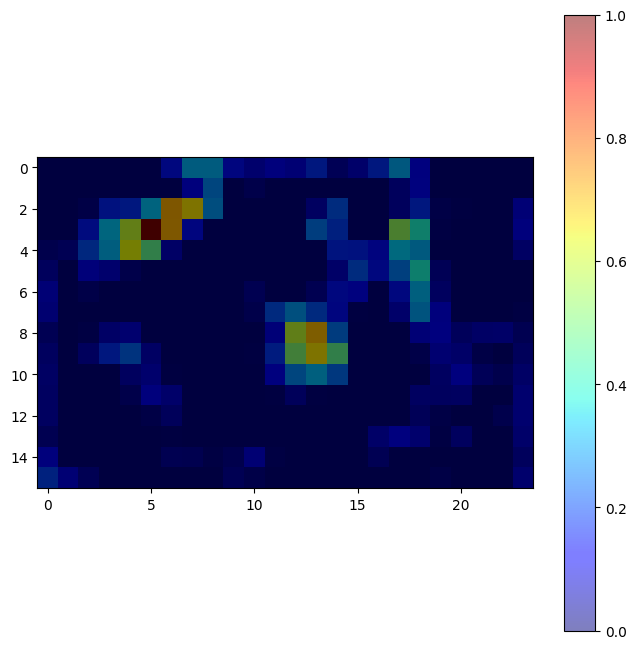

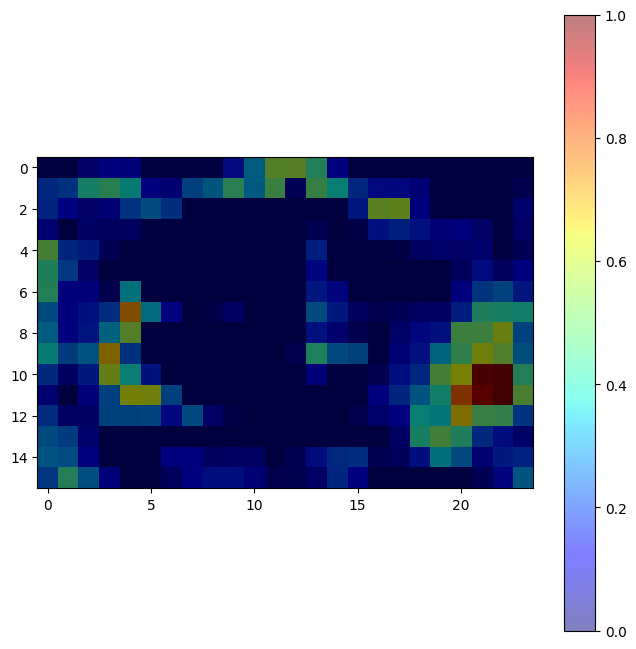

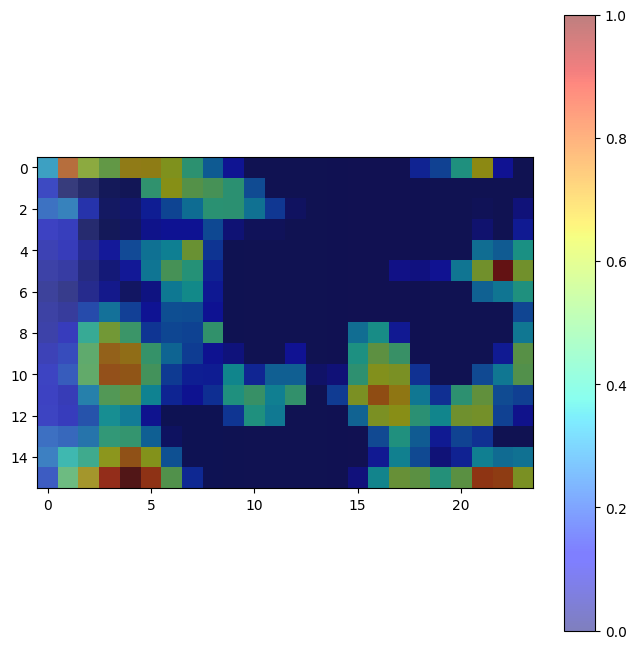

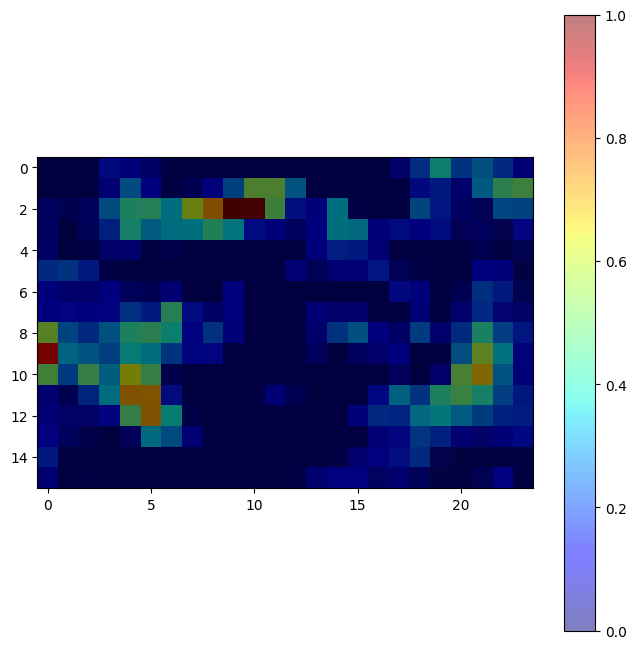

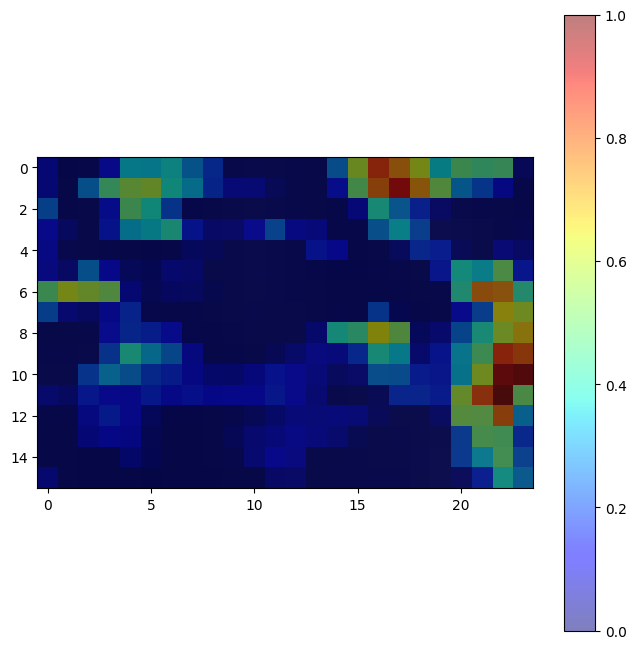

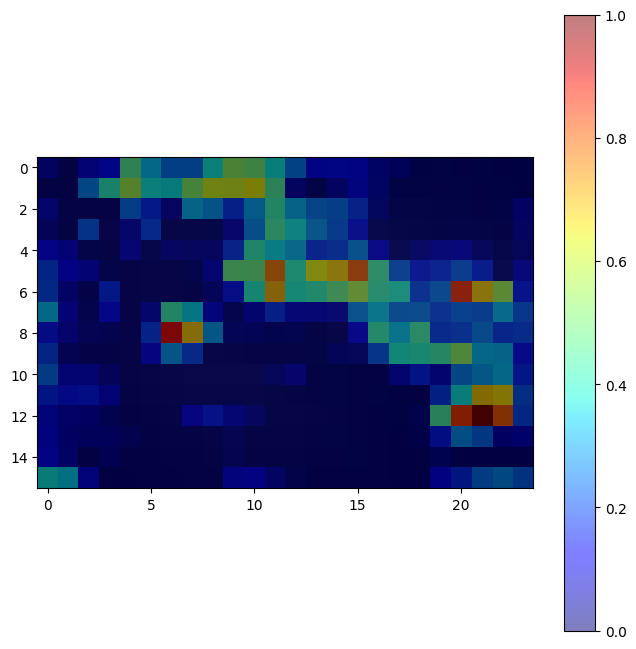

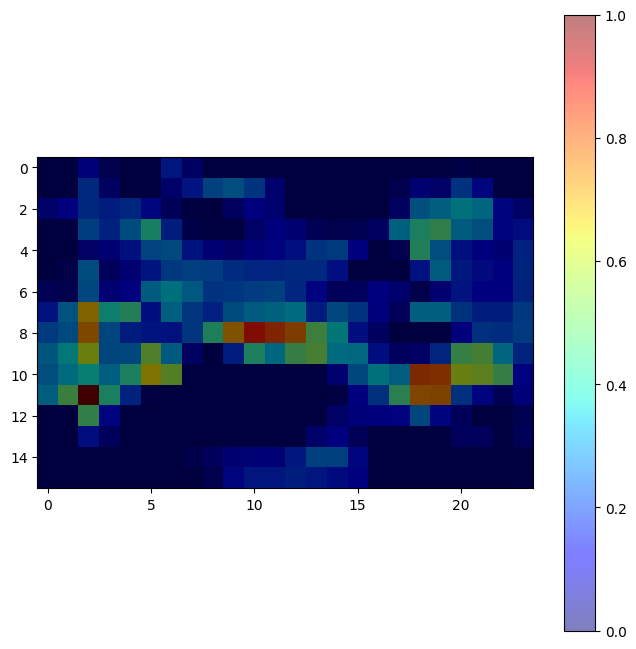

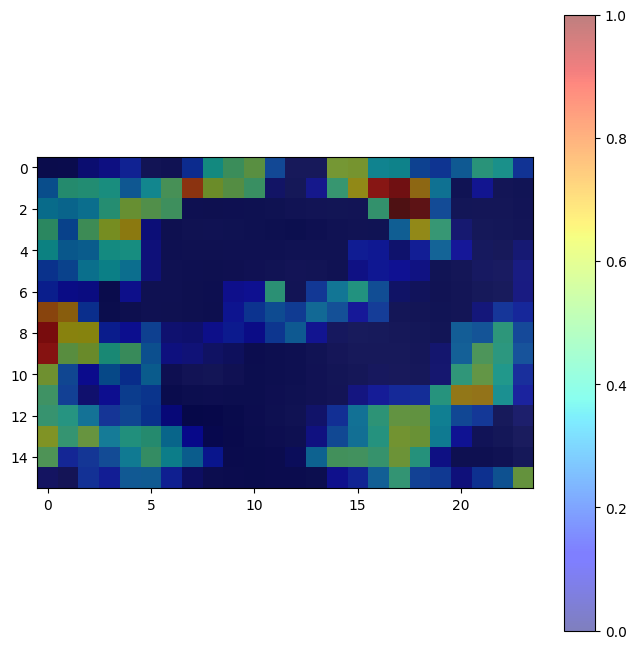

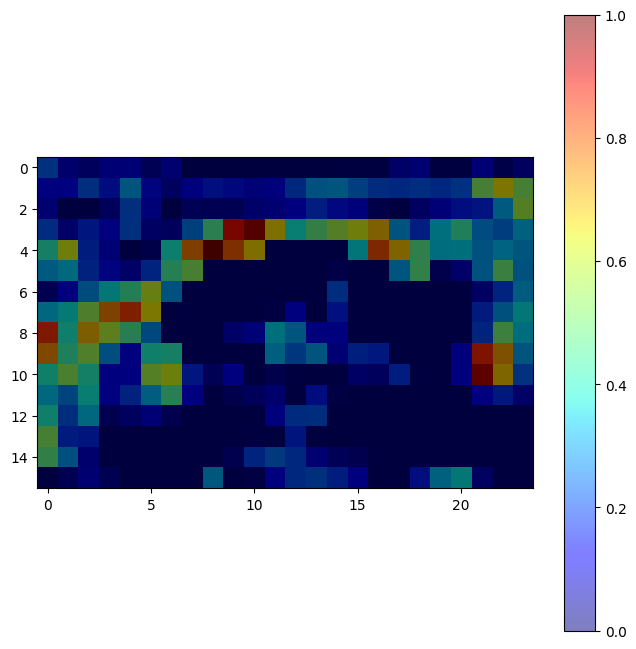

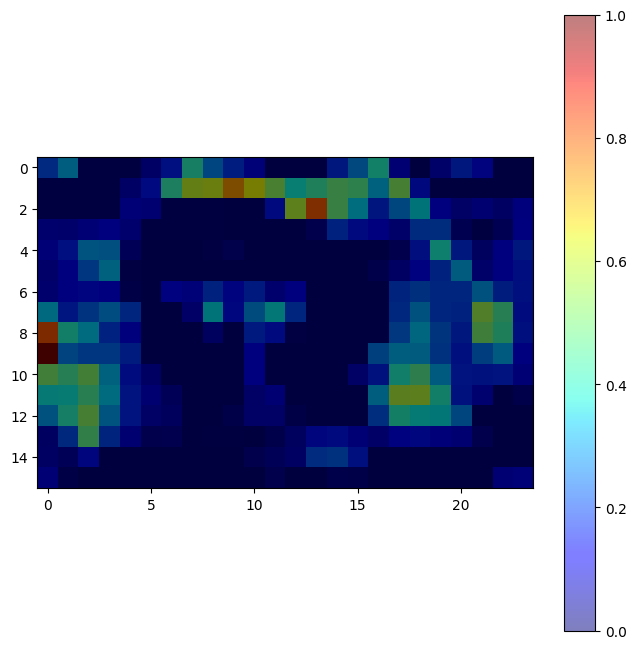

Mean: tensor([0.2139, 0.2333, 0.2465], device='cuda:0')
Std: tensor([0.1744, 0.1866, 0.1891], device='cuda:0')


In [37]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-34 model
resnet = models.resnet34(pretrained=True).to(device)
resnet.eval()

# Define hook to retrieve activations from the last convolutional layer
activation = {}
def hook(module, input, output):
    activation['value'] = output
resnet.layer4[1].register_forward_hook(hook)  # Register hook on the last convolutional layer of ResNet-34

# Function to plot activation map overlay on the original image
def plot_activation_map(image_tensor, activation_map):
    # Convert activation map to a grayscale image
    activation_map = activation_map[0]

    # Normalize the activation map
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

    # Overlay activation map on the original image
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())
    im = ax.imshow(activation_map, cmap='jet', alpha=0.5, vmin=0, vmax=1)
    fig.colorbar(im, ax=ax)
    plt.show()


# Function to calculate mean and standard deviation of input images
def calculate_mean_std(image_folder, device):
    transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
    ])
    mean = 0.0
    std = 0.0
    total_images = 0
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image).to(device)
            mean += image_tensor.mean((1, 2))
            std += image_tensor.std((1, 2))
            total_images += 1
            if total_images <= 20:  # Visualize only for the first 5 images
                # Forward pass the image through the model
                with torch.no_grad():
                    _ = resnet(image_tensor.unsqueeze(0))

                # Visualize the activations of the first channel
                activation_map = activation['value'].squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
                plot_activation_map(image_tensor, activation_map)

    mean /= total_images
    std /= total_images
    return mean, std

# Ask for image folder path
image_folder = ("/home/user/Desktop/aman/data/clean_khurana_HEAD_IMAGES_SORTED FINAL_VALID")

# Calculate mean and standard deviation of input images
mean, std = calculate_mean_std(image_folder, device)
print("Mean:", mean)
print("Std:", std)


In [1]:
pwd

'/home/user/Desktop/aman/imaging_venv/codes'

In [ ]:
sheet1_path = ('/home/user/Downloads/Fup1 Query.xlsx')
sheet2_path = ('/home/user/Downloads/COVID19_IDENTIFICATION FORM (Responses).xlsx')


In [7]:
import pandas as pd
import re

# Prompt user for paths of both Excel sheets
sheet1_path = ('/home/user/Downloads/Fup1 Query.xlsx')
sheet2_path = ('/home/user/Downloads/COVID19_IDENTIFICATION FORM (Responses).xlsx')

# Load both Excel sheets
sheet1 = pd.read_excel(sheet1_path, sheet_name='Did symptom is blank')
sheet2 = pd.read_excel(sheet2_path, sheet_name='Form responses 1')

# Find the column containing 'Enrolment ID' using a regular expression
enrolment_id_column_sheet1 = next(filter(lambda col: re.search(r'Enrolment\s*ID', col, re.IGNORECASE), sheet1.columns))
enrolment_id_column_sheet2 = next(filter(lambda col: re.search(r'Enrolment\s*ID', col, re.IGNORECASE), sheet2.columns))

# Extract Enrolment ID from both sheets
sheet1[enrolment_id_column_sheet1] = sheet1[enrolment_id_column_sheet1].str.split().str[0]
sheet2[enrolment_id_column_sheet2] = sheet2[enrolment_id_column_sheet2].str.split().str[0]

# Merge the two sheets based on Enrolment ID and '1.2 Fever' columns
merged = pd.merge(sheet1, sheet2[['Enrolment ID', '1.2 Fever']], left_on=enrolment_id_column_sheet1, right_on=enrolment_id_column_sheet2, how='left')

# Fill NaN values in '1.2 Fever_enr' column with corresponding values from sheet2
merged['1.2 Fever_enr'] = merged['1.2 Fever_enr'].fillna(merged['1.2 Fever'])

# Save the result to a new Excel file or do further processing as needed
merged.to_excel('merged.xlsx', index=False)


KeyError: "['Enrolment ID'] not in index"

In [10]:
import pandas as pd
import re

# Prompt user for paths of both Excel sheets
sheet1_path = ('/home/user/Downloads/Fup1 Query.xlsx')
sheet2_path = ('/home/user/Downloads/COVID19_IDENTIFICATION FORM (Responses).xlsx')

# Load both Excel sheets
sheet1 = pd.read_excel(sheet1_path, sheet_name='Did symptom is blank')
sheet2 = pd.read_excel(sheet2_path, sheet_name='Form responses 1')

# Find the column containing 'Enrolment ID' using a regular expression pattern
pattern_sheet1 = re.compile(r'Enrolment\s*ID.*C-Centre-ID', flags=re.IGNORECASE)
enrolment_id_column_sheet1 = next(filter(lambda col: pattern_sheet1.search(col), sheet1.columns), None)

pattern_sheet2 = re.compile(r'Enrolment\s*ID.*Lab received the sample', flags=re.IGNORECASE)
enrolment_id_column_sheet2 = next(filter(lambda col: pattern_sheet2.search(col), sheet2.columns), None)

if not enrolment_id_column_sheet1:
    print("Enrolment ID column not found in Sheet1.")
else:
    print(f"Enrolment ID column found in Sheet1: {enrolment_id_column_sheet1}")

if not enrolment_id_column_sheet2:
    print("Enrolment ID column not found in Sheet2.")
else:
    print(f"Enrolment ID column found in Sheet2: {enrolment_id_column_sheet2}")

if not enrolment_id_column_sheet1 or not enrolment_id_column_sheet2:
    print("Unable to proceed with merging due to missing Enrolment ID column(s).")
else:
    # Extract Enrolment ID from both sheets
    sheet1[enrolment_id_column_sheet1] = sheet1[enrolment_id_column_sheet1].str.split().str[0]
    sheet2[enrolment_id_column_sheet2] = sheet2[enrolment_id_column_sheet2].str.split().str[0]

    # Merge the two sheets based on Enrolment ID and '1.2 Fever' columns
    merged = pd.merge(sheet1, sheet2[['Enrolment ID', '1.2 Fever']], left_index=True, right_index=True, how='left')

    # Fill NaN values in '1.2 Fever_enr' column with corresponding values from sheet2
    merged['1.2 Fever_enr'] = merged['1.2 Fever_enr'].fillna(merged['1.2 Fever'])

    # Save the result to a new Excel file or do further processing as needed
    merged.to_excel('merged.xlsx', index=False)


Enrolment ID column found in Sheet1: Enrolment ID (* format C-Centre-ID)
Enrolment ID column found in Sheet2: Enrolment ID (will be updated once Lab received the sample)


KeyError: "['Enrolment ID'] not in index"